# Estimación de Masas Nucleares Mediante Redes Neuronales Probabilísticas y Random Forest

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Datos de AME(2020) y NNDC

AME(2020) data: https://www-nds.iaea.org/amdc/ame2020/mass_1.mas20.txt

AME(2020) artículo: https://doi.org/10.1088/1674-1137/abddaf

NNDC: https://www.nndc.bnl.gov/


In [2]:
# Base de datos AME 2020
mass = pd.read_csv("NUBASE1.csv")
mass.columns = ['AAA','ZZZi','AEl', 's', 'Mass', 'dMass']
mass['Mass'] = mass['Mass'].str.replace('#', '.0')
mass['dMass'] = mass['dMass'].str.replace('#', '.0')
mass['ZZZi'] = mass['ZZZi'].astype(str).str[:-1].astype(np.int64)
mass['AAA'] = mass['AAA']
mass = mass.sort_values('ZZZi')
mass = mass.reset_index()
mass = mass.drop('index',axis = 1)
mass = mass.drop('s', axis = 1)
mass

,AAA,ZZZi,AEl,Mass,dMass
0,1,1,1H,7288.971064,1E-05
1,2,1,2H,13135.722895,1E-05
2,3,1,3H,14949.8109,8E-05
3,7,1,7H,49140.0,1000.0
4,4,1,4H,24620,100
...,...,...,...,...,...
5837,293,117,293Ts,194430.0,780.0
5838,294,117,294Ts,196400.0,590.0
5839,294,118,294Og,199320.0,550.0
5840,293,118,293Og,198800.0,710.0


In [3]:
# Energía de primer estado excitado de NNDC
first_ex = pd.read_csv("1st_ExcitedStateEnergy.csv")
first_ex.z = first_ex.z
first_ex.n = first_ex.n
first_ex.columns = ['n','z','First']
first_ex = first_ex.sort_values('z')
first_ex['First'] = first_ex['First']/1000
first_ex

,n,z,First
0,3,1,0.310
1,4,1,3.100
2,5,1,4.100
3,6,1,15.000
4,2,2,20.210
...,...,...,...
2187,158,108,0.085
2188,159,108,0.057
2190,163,110,0.283
2189,160,110,1.130


In [4]:
# Se crea una nueva característica energía del primer estado excitado
mass['FirstExc'] = np.nan

# Se asignan los valores de la energía del primer estado excitado a los correspondientes Z y N

for i in range(len(np.array(first_ex.index))):
    
    A = first_ex.at[i,'z'] + first_ex.at[i,'n']
    FE = first_ex.at[i,'First']
    
    for j in range(len(np.array(mass.index))):
        
        if (first_ex.at[i,'z'] == mass.at[j, 'ZZZi']):
                        
            if (float(A) == float(mass.at[j, 'AAA'])):
                mass.at[j, 'FirstExc'] = FE
                break

        if first_ex.at[i,'z'] < mass.at[j, 'ZZZi']:
            break

In [5]:
# Se incluye el número de neutrones
mass['NNNi'] = mass['AAA']-mass['ZZZi']

In [6]:
# Se incluye los nucleones por fuera o faltantes de las capas N,Z = 2,8,20,18,50,82,126
mass['DeltaZ']=np.nan
mass['DeltaN']=np.nan
mass['Zshell']=np.nan
mass['Nshell']=np.nan

for i in range(len(np.array(mass.index))):
    
    Z = mass.at[i,'ZZZi']
    
    # Se llena la característica DeltaZ
    if (0 <= Z < 2):
        mass.at[i,'DeltaZ'] = min(abs(Z-0),abs(Z-2))
        
    if (2 <= Z < 8):
        mass.at[i,'DeltaZ'] = min(abs(Z-2),abs(Z-8))  

    if (8 <= Z < 20):
        mass.at[i,'DeltaZ'] = min(abs(Z-8),abs(Z-20))            

    if (20 <= Z < 28):
        mass.at[i,'DeltaZ'] = min(abs(Z-20),abs(Z-28))            

    if (28 <= Z < 50):
        mass.at[i,'DeltaZ'] = min(abs(Z-28),abs(Z-50))            

    if (50 <= Z < 82):
        mass.at[i,'DeltaZ'] = min(abs(Z-50),abs(Z-82))            

    if (82 <= Z < 126):
        mass.at[i,'DeltaZ'] = min(abs(Z-82),abs(Z-126))            
        
    if (126 <= Z ):
        mass.at[i,'DeltaZ'] = abs(Z-126)  
        
        
    N = mass.at[i,'NNNi']
        
    # Se llena la característica DeltaN
    if (0 <= N < 2):
        mass.at[i,'DeltaN'] = min(abs(N-0),abs(N-2)) 
        
    if (2 <= N < 8):
        mass.at[i,'DeltaN'] = min(abs(N-2),abs(N-8))

    if (8 <= N < 20):
        mass.at[i,'DeltaN'] = min(abs(N-8),abs(N-20))            

    if (20 <= N < 28):
        mass.at[i,'DeltaN'] = min(abs(N-20),abs(N-28))            

    if (28 <= N < 50):
        mass.at[i,'DeltaN'] = min(abs(N-28),abs(N-50))            

    if (50 <= N < 82):
        mass.at[i,'DeltaN'] = min(abs(N-50),abs(N-82))            

    if (82 <= N < 126):
        mass.at[i,'DeltaN'] = min(abs(N-82),abs(N-126))            
        
    if (126 <= N ):
        mass.at[i,'DeltaN'] = abs(N-126)            

In [7]:
# Se incluye la suma de los nucleones totales por fuera o faltantes en una capa cerrada
mass['DeltaSum'] = mass['DeltaZ'] + mass['DeltaN']

In [8]:
# Se añaden las demás características del modelo de gota líquida
mass['A^2/3']  = mass['AAA']**(2/3)
mass['Z(Z-1)/A^1/3']  = mass['ZZZi']*(mass['ZZZi']-1.0)/mass['AAA']**(1/3)
mass['(N-Z)^2/A']  = (mass['NNNi'] - mass['ZZZi'])**2/mass['AAA']
mass['ZEO'] = np.nan
mass['NEO'] = np.nan

for i in range(len(np.array(mass.index))):

    if (mass.at[i,'ZZZi']%2 == 0):
        mass.at[i,'ZEO']  = 0 
    else:
        mass.at[i,'ZEO']  = 1
        
    if (mass.at[i,'NNNi']%2 == 0):
        mass.at[i,'NEO']  = 0 
    else:
        mass.at[i,'NEO']  = 1

In [9]:
# Se guardan los datos del dataframe con 12 características a implementar
mass = mass.dropna(subset=['Mass'])
mass.reset_index()
mass.to_csv('FULLCHAR.csv', index = False)

In [3]:
massF = pd.read_csv("FULLCHAR.csv")
massF['Mass'] = massF['Mass']/1000
massF

,AAA,ZZZi,AEl,Mass,dMass,FirstExc,NNNi,DeltaZ,DeltaN,Zshell,Nshell,DeltaSum,A^2/3,Z(Z-1)/A^1/3,(N-Z)^2/A,ZEO,NEO
0,1,1,1H,7.288971,0.00001,NaN,0,1.0,0.0,NaN,NaN,1.0,1.000000,0.000000,1.000000,1.0,0.0
1,2,1,2H,13.135723,0.00001,NaN,1,1.0,1.0,NaN,NaN,2.0,1.587401,0.000000,0.000000,1.0,1.0
2,3,1,3H,14.949811,0.00008,NaN,2,1.0,0.0,NaN,NaN,1.0,2.080084,0.000000,0.333333,1.0,0.0
3,7,1,7H,49.140000,1000.00000,15.00,6,1.0,2.0,NaN,NaN,3.0,3.659306,0.000000,3.571429,1.0,0.0
4,4,1,4H,24.620000,100.00000,0.31,3,1.0,1.0,NaN,NaN,2.0,2.519842,0.000000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,293,117,293Ts,194.430000,780.00000,NaN,176,9.0,50.0,NaN,NaN,59.0,44.114201,2043.405906,11.880546,1.0,0.0
5822,294,117,294Ts,196.400000,590.00000,NaN,177,9.0,51.0,NaN,NaN,60.0,44.214517,2041.086487,12.244898,1.0,1.0
5823,294,118,294Og,199.320000,550.00000,NaN,176,8.0,50.0,NaN,NaN,58.0,44.214517,2076.277633,11.442177,0.0,0.0
5824,293,118,293Og,198.800000,710.00000,NaN,175,8.0,49.0,NaN,NaN,57.0,44.114201,2078.637042,11.088737,0.0,1.0


#### Gráficas del déficit de masa

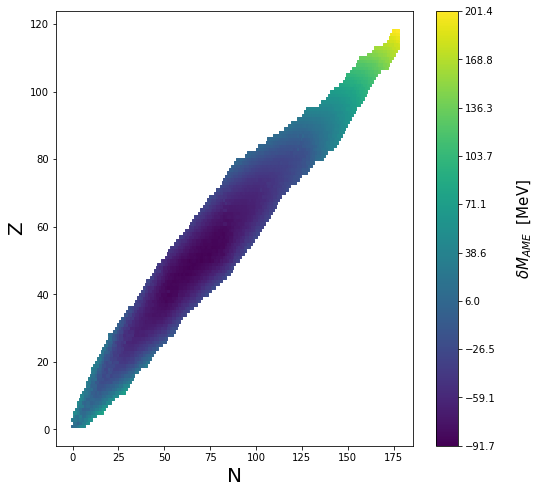

In [11]:
# Gráficas de N,Z vs deficit de mass
%matplotlib inline
fig = plt.figure(figsize = (8,8))
x = massF['NNNi'].to_numpy()
y = massF['ZZZi'].to_numpy()
cmass = massF['Mass'].to_numpy()
plt.scatter(x,y, c = cmass, marker=',', s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)

# Función para notación científica
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

#Argumento de plt.colorbar: format=ticker.FuncFormatter(fmt)

plt.colorbar(ticks=np.linspace(min(cmass),max(cmass),10)).set_label(label='$\delta M_{AME}$  [MeV]', size=15, labelpad=20)
plt.savefig('DeltaMedidas.png',dpi = 500)
plt.show()

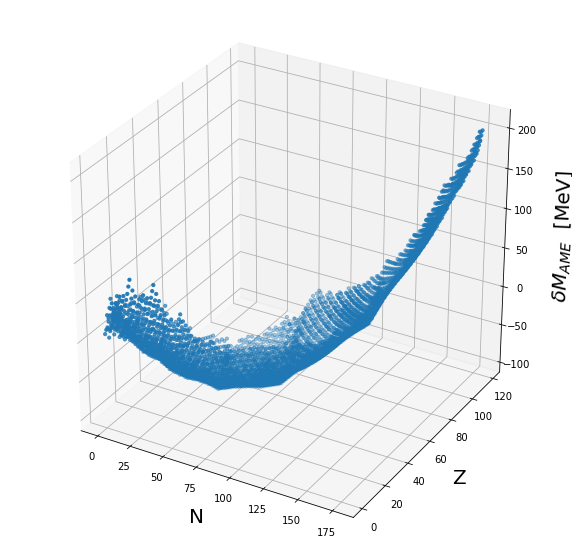

In [5]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plot = plt.figure(figsize=(10,10)).gca(projection='3d')
plot.scatter(np.array(massF['NNNi']), np.array(massF['ZZZi']), np.array(massF['Mass']), s = 10)
plot.set_xlabel('N', fontsize= 20, labelpad=10)
plot.set_ylabel('Z', fontsize= 20, labelpad=10)
plot.set_zlabel('$\delta M_{AME}$  [MeV]', fontsize= 20, labelpad=20)
plt.savefig('DeltaMedidas3D.png',dpi = 500)
plt.show()

#### Energía del primer estado excitado

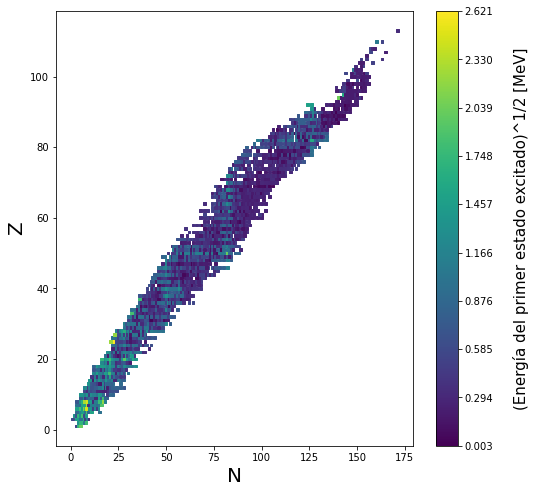

In [13]:
first_excopy = first_ex[first_ex.First != first_ex['First'].max()]
first_excopy = first_excopy[first_excopy.First != first_excopy['First'].max()]
first_excopy = first_excopy[first_excopy.First != first_excopy['First'].max()]

nn = first_excopy['n'].to_numpy()
zz = first_excopy['z'].to_numpy()
first = np.sqrt(first_excopy['First'].to_numpy())

fig = plt.figure(figsize = (8,8))
plt.scatter(nn,zz, c = first, s = 7 ,marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(first),max(first),10)).set_label(label='(Energía del primer estado excitado)^1/2 [MeV]', size=15, labelpad=20)
plt.savefig('PrimerEExc.png',dpi = 500)
plt.show()

# SE GRAFICA LA RAÍZ CUADRADA DE LA ENERGÍA DEL PRIMER ESTADO EXCITADO Y SE ELIMINAN (SOLO PARA LA GRÁFICA) 
# LOS TRES VALORES MAYORES CON EL PROPÓSITO DE MOSTRAR MÁS CLARAMENTE LA INFORMACIÓN DE LA ESTRUCTURA QUE ESTA 
#CARACTERÍSTICA POSEE

#### Gráficas de las características $\Delta$N, $\Delta$Z y $\Delta$A = $\Delta$(N+Z)

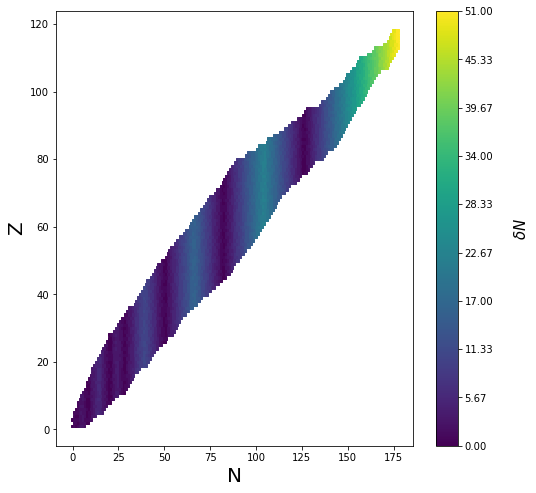

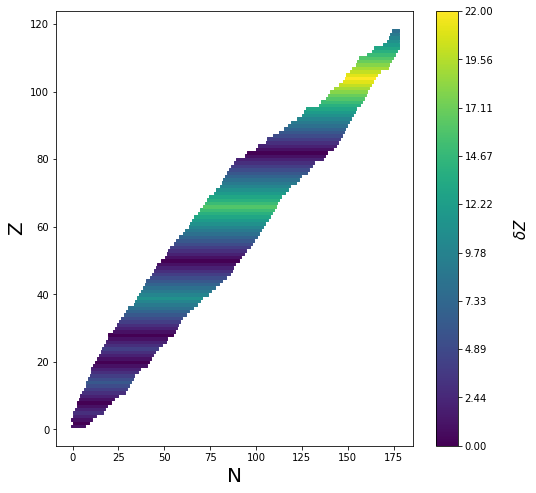

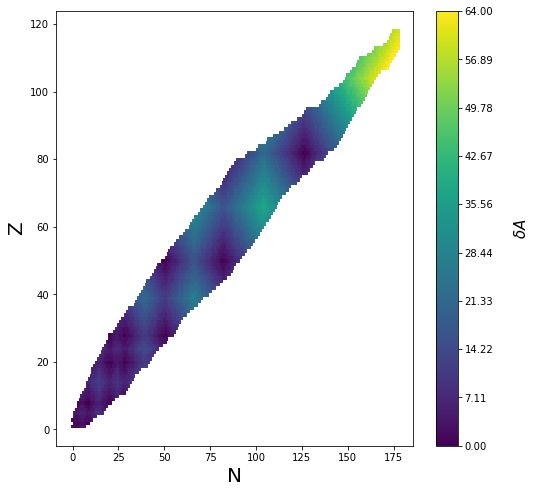

In [14]:
DN = massF['DeltaN'].to_numpy()
DZ = massF['DeltaZ'].to_numpy()
DS = massF['DeltaSum'].to_numpy()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DN ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(DN),max(DN),10)).set_label(label='$\delta N$', size=15, labelpad=20)
plt.savefig('DeltaN.png',dpi = 500)
plt.show()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DZ ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(DZ),max(DZ),10)).set_label(label='$\delta Z$', size=15, labelpad=20)
plt.savefig('DeltaZ.png',dpi = 500)
plt.show()


fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DS ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(DS),max(DS),10)).set_label(label='$\delta A$', size=15, labelpad=20)
plt.savefig('DeltaS.png',dpi = 500)
plt.show()

#### Gráficas de las características del modelo de gota líquida: términos de superficie, interacción Coulumbiana y asimetría

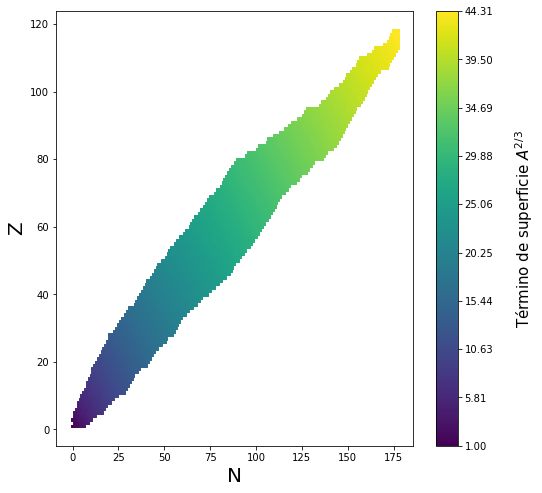

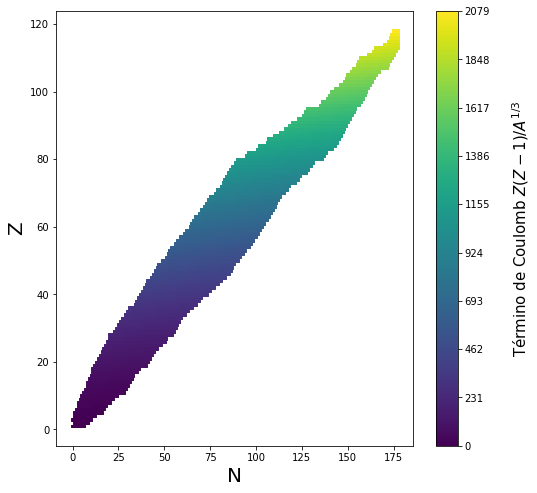

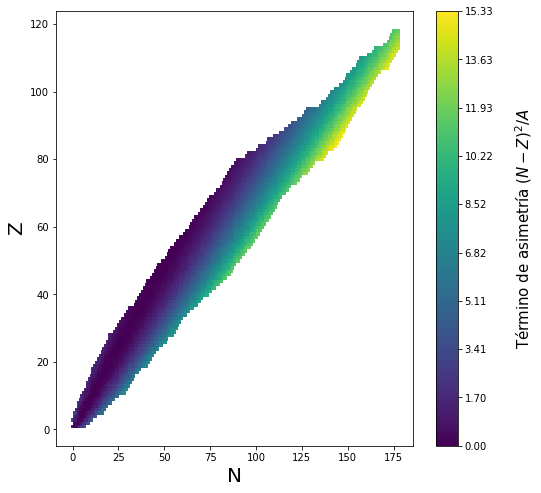

In [15]:
SURF = massF['A^2/3'].to_numpy()
COUL = massF['Z(Z-1)/A^1/3'].to_numpy()
SYMM = massF['(N-Z)^2/A'].to_numpy()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = SURF ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(SURF),max(SURF),10)).set_label(label='Término de superficie $A^{2/3}$', size=15, labelpad=20)
plt.savefig('A23.png',dpi = 500)
plt.show()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = COUL ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(COUL),max(COUL),10)).set_label(label='Término de Coulomb $Z(Z-1)/A^{1/3}$', size=15, labelpad=20)
plt.savefig('Coulomb.png',dpi = 500)
plt.show()


fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = SYMM ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(SYMM),max(SYMM),10)).set_label(label='Término de asimetría $(N-Z)^2/A$', size=15, labelpad=20)
plt.savefig('Asymm.png',dpi = 500)
plt.show()

In [17]:
# Error raíz cuadrático medio del modelo para calcular la bondad de ajuste
def RMS(Medidas,Prediccion):
    M = np.array(Medidas)
    P = np.array(Prediccion)
    return (sum((M-P)**2)/len(P))**(0.5)  

# Modelos M12 y M11

## M12
Datos de déficit de masas con 12 características

In [18]:
# Datos M12: Ajuste de déficit de masas con 12 características
massF12 = massF
massF12 = massF12.dropna(subset=['FirstExc'])
massF12 = massF12.dropna(subset=['Mass'])

# Se separan los datos de test y de train
from sklearn.model_selection import train_test_split
massF12train, massF12test, p, q = train_test_split(massF12, massF12['Mass'], test_size=0.2, random_state=42)
    
# Arreglo con los datos. Características por filas y datos por columnas
X12TRNN = massF12train[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'FirstExc', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()
X12TENN = massF12test[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'FirstExc', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()

# Mínimos y máximos para la normalización
minX12 = massF12[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'FirstExc', 'DeltaZ', 'DeltaN', 'DeltaSum']].min().to_numpy()
maxX12 = massF12[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'FirstExc', 'DeltaZ', 'DeltaN', 'DeltaSum']].max().to_numpy()

minY12 = massF12['Mass'].min()
maxY12 = massF12['Mass'].max()
                                                                                          
# ===================================================================================

# Se normalizan los datos
X12TR = X12TRNN.copy()
X12TR = X12TR.transpose()                       # Para transponer por característica
for i in range(X12TR.shape[0]):
    X12TR[i] = (X12TR[i]-minX12[i])/(maxX12[i]-minX12[i])
X12TR = X12TR.transpose()

print('\nDatos de entrenamiento normalizados 12 características:\n\n')
print('X =',X12TR, '\n\n Dimensiones:', X12TR.shape)

# Masas entrenamiento
Y12TRNN = massF12train['Mass'].to_numpy()
Y12TR = Y12TRNN.copy()
Y12TR = (Y12TR-minY12)/(maxY12-minY12)
Y12TR = Y12TR.reshape(np.shape(X12TR)[0],-1)
print('\n\nY =',Y12TR, '\n\n Dimensiones:', Y12TR.shape)

# ===================================================================================

# Se normalizan los datos
X12TE = X12TENN.copy()
X12TE = X12TE.transpose()
for i in range(X12TE.shape[0]):
    X12TE[i] = (X12TE[i]-minX12[i])/(maxX12[i]-minX12[i])
X12TE = X12TE.transpose()


print('\nDatos de test normalizados 12 características:\n\n')
print('X =',X12TE, '\n\n Dimensiones:', X12TE.shape)

# Masas test
Y12TENN = massF12test['Mass'].to_numpy()
Y12TE = Y12TENN.copy()
Y12TE = (Y12TE-minY12)/(maxY12-minY12)
Y12TE = Y12TE.reshape(np.shape(X12TE)[0],-1)
print('\n\nY =',Y12TE, '\n\n Dimensiones:', Y12TE.shape)


Datos de entrenamiento normalizados 12 características:


X = [[0.11071429 0.11607143 0.11764706 ... 0.27272727 0.02222222 0.12068966]
 [0.83571429 0.83928571 0.83529412 ... 0.59090909 0.37777778 0.51724138]
 [0.54285714 0.53571429 0.55294118 ... 0.5        0.28888889 0.4137931 ]
 ...
 [0.46071429 0.48214286 0.45294118 ... 0.22727273 0.08888889 0.15517241]
 [0.46071429 0.54464286 0.41176471 ... 0.54545455 0.24444444 0.39655172]
 [0.35714286 0.40178571 0.33529412 ... 0.18181818 0.17777778 0.20689655]] 

 Dimensiones: (1752, 12)


Y = [[0.29884233]
 [0.54218255]
 [0.10599568]
 ...
 [0.0133856 ]
 [0.13333533]
 [0.00825551]] 

 Dimensiones: (1752, 1)

Datos de test normalizados 12 características:


X = [[0.16071429 0.22321429 0.12941176 ... 0.09090909 0.06666667 0.0862069 ]
 [0.30357143 0.33035714 0.29411765 ... 0.45454545 0.02222222 0.18965517]
 [0.56428571 0.66964286 0.5        ... 0.27272727 0.08888889 0.17241379]
 ...
 [0.51071429 0.5        0.52352941 ... 0.31818182 0.17777778 0.258

#### Gráfica de datos de trainig y entrenamiento para el modelo M12

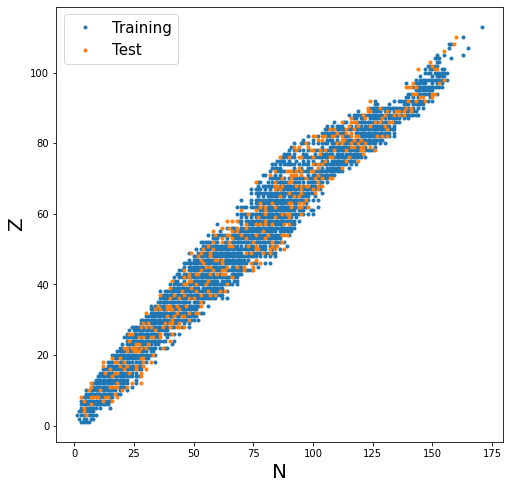

In [7]:
fig = plt.figure(figsize = (8,8))
plt.plot(X12TRNN[:,2],X12TRNN[:,1], '.', label = 'Training')
plt.plot(X12TENN[:,2],X12TENN[:,1], '.', label = 'Test')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.legend(fontsize=15)
plt.savefig('M12TT.png',dpi = 500)
plt.show()

## M11
Datos de déficit de masas con 11 características. Eliminando la energía del primer estado excitado


### Datos de test FRDM(2012) para el modelo M11

FRDM(2012) data: https://t2.lanl.gov/nis/molleretal/publications/ADNDT-FRDM2012.html

FRDM(2012) artículo: https://arxiv.org/pdf/1508.06294.pdf

In [19]:
# Datos de test
test = pd.read_csv('FRDM2012.csv')
test.columns = ['Z','N','A','MthFL']
test

,Z,N,A,MthFL
0,8,8,16,-5.15
1,8,9,17,-1.49
2,8,10,18,-2.81
3,8,11,19,2.15
4,8,12,20,2.19
...,...,...,...,...
9313,135,201,336,349.30
9314,135,202,337,349.90
9315,135,203,338,351.39
9316,135,204,339,352.48


In [21]:
# Se incluye los nucleones por fuera o faltantes de las capas N,Z = 2,8,20,18,50,82,126
test['DeltaZ']=np.nan
test['DeltaN']=np.nan

for i in range(len(np.array(test.index))):
    
    Z = test.at[i,'Z']
    
    # Se llena la característica DeltaZ
    if (0 <= Z < 2):
        test.at[i,'DeltaZ'] = min(abs(Z-0),abs(Z-2))
        
    if (2 <= Z < 8):
        test.at[i,'DeltaZ'] = min(abs(Z-2),abs(Z-8))  

    if (8 <= Z < 20):
        test.at[i,'DeltaZ'] = min(abs(Z-8),abs(Z-20))            

    if (20 <= Z < 28):
        test.at[i,'DeltaZ'] = min(abs(Z-20),abs(Z-28))            

    if (28 <= Z < 50):
        test.at[i,'DeltaZ'] = min(abs(Z-28),abs(Z-50))            

    if (50 <= Z < 82):
        test.at[i,'DeltaZ'] = min(abs(Z-50),abs(Z-82))            

    if (82 <= Z < 126):
        test.at[i,'DeltaZ'] = min(abs(Z-82),abs(Z-126))            
        
    if (126 <= Z ):
        test.at[i,'DeltaZ'] = abs(Z-126)  
        
        
    N = test.at[i,'N']
        
    # Se llena la característica DeltaN
    if (0 <= N < 2):
        test.at[i,'DeltaN'] = min(abs(N-0),abs(N-2)) 
        
    if (2 <= N < 8):
        test.at[i,'DeltaN'] = min(abs(N-2),abs(N-8))

    if (8 <= N < 20):
        test.at[i,'DeltaN'] = min(abs(N-8),abs(N-20))            

    if (20 <= N < 28):
        test.at[i,'DeltaN'] = min(abs(N-20),abs(N-28))            

    if (28 <= N < 50):
        test.at[i,'DeltaN'] = min(abs(N-28),abs(N-50))            

    if (50 <= N < 82):
        test.at[i,'DeltaN'] = min(abs(N-50),abs(N-82))            

    if (82 <= N < 126):
        test.at[i,'DeltaN'] = min(abs(N-82),abs(N-126))            
        
    if (126 <= N ):
        test.at[i,'DeltaN'] = abs(N-126)  
        
test['DeltaSum'] = test['DeltaZ'] + test['DeltaN']

# Se añaden las demás características del modelo de gota líquida
test['A^2/3']  = test['A']**(2/3)
test['Z(Z-1)/A^1/3']  = test['Z']*(test['Z']-1.0)/test['A']**(1/3)
test['(N-Z)^2/A']  = (test['N'] - test['Z'])**2/test['A']
test['ZEO'] = np.nan
test['NEO'] = np.nan

for i in range(len(np.array(test.index))):

    if (test.at[i,'Z']%2 == 0):
        test.at[i,'ZEO']  = 0 
    else:
        test.at[i,'ZEO']  = 1
        
    if (test.at[i,'N']%2 == 0):
        test.at[i,'NEO']  = 0 
    else:
        test.at[i,'NEO']  = 1

In [22]:
# Se guardan los datos de test
test.to_csv('TESTDATAv3.csv', index = False)

In [20]:
# Dataframe con los datos de entrenamiento
Test = pd.read_csv("TESTDATAv3.csv")
Test

,Z,N,A,MthFL,DeltaZ,DeltaN,DeltaSum,A^2/3,Z(Z-1)/A^1/3,(N-Z)^2/A,ZEO,NEO
0,8,8,16,-5.15,0.0,0.0,0.0,6.349604,22.223615,0.000000,0.0,0.0
1,8,9,17,-1.49,0.0,1.0,1.0,6.611489,21.779023,0.058824,0.0,1.0
2,8,10,18,-2.81,0.0,2.0,2.0,6.868285,21.367999,0.222222,0.0,0.0
3,8,11,19,2.15,0.0,3.0,3.0,7.120367,20.986346,0.473684,0.0,1.0
4,8,12,20,2.19,0.0,4.0,4.0,7.368063,20.630576,0.800000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9313,135,201,336,349.30,9.0,75.0,84.0,48.331045,2602.108938,12.964286,1.0,1.0
9314,135,202,337,349.90,9.0,76.0,85.0,48.426892,2599.532590,13.320475,1.0,0.0
9315,135,203,338,351.39,9.0,77.0,86.0,48.522645,2596.966416,13.680473,1.0,1.0
9316,135,204,339,352.48,9.0,78.0,87.0,48.618303,2594.410345,14.044248,1.0,0.0


In [21]:
# Datos M11: Ajuste de déficit de masas con 11 características
massF11=massF
massF11 = massF11.drop(columns=['FirstExc'])
massF11 = massF11.dropna(subset=['Mass'])

# Arreglos con los datos. Características por filas y datos por columnas
X11NN = massF11[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()
XTNN = Test[['A','Z', 'N', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()
ALLXM11 = pd.DataFrame(np.concatenate((XTNN, X11NN)))
ALLYM11 = np.concatenate((massF11['Mass'].to_numpy(),  Test['MthFL'].to_numpy()))

# Mínimos y máximos para la normalización
minX11 = ALLXM11.min().to_numpy()
maxX11 = ALLXM11.max().to_numpy()

minY11 = min(ALLYM11)
maxY11 = max(ALLYM11)

# ====================================================================================

# Se normalizan los datos
X11 = X11NN.copy()
X11 = X11.transpose()
for i in range(X11.shape[0]):
    X11[i] = (X11[i]-minX11[i])/(maxX11[i]-minX11[i])
X11 = X11.transpose()

print('\nDatos de entrenamiento normalizados 11 características:\n\n')
print('X =',X11, '\n\n Dimensiones:', X11.shape)

# Masas
Y11NN = massF11['Mass'].to_numpy()
Y11 = Y11NN.copy()
Y11 = (Y11-minY11)/(maxY11-minY11)
Y11 = Y11.reshape(5826,-1)
print('\n\nY =',Y11, '\n\n Dimensiones:', Y11.shape)

# ====================================================================================

# Se normalizan los datos
XT = XTNN.copy()
XT = XT.transpose()
for i in range(XT.shape[0]):
    XT[i] = (XT[i]-minX11[i])/(maxX11[i]-minX11[i])
XT = XT.transpose()

print('\nDatos de test:\n\n')
print('X =',XT, '\n\n Dimensiones:', XT.shape)

YTNN = Test['MthFL'].to_numpy()
YT = YTNN.copy()
YT = (YT-minY11)/(maxY11-minY11)
YT = YT.reshape(XT.shape[0],-1)

print('\n\nY =',YT, '\n\n Dimensiones:', YT.shape)


Datos de entrenamiento normalizados 11 características:


X = [[0.         0.         0.         ... 0.04545455 0.         0.00763359]
 [0.00295858 0.         0.00423729 ... 0.04545455 0.00909091 0.01526718]
 [0.00591716 0.         0.00847458 ... 0.04545455 0.         0.00763359]
 ...
 [0.86686391 0.86666667 0.74576271 ... 0.36363636 0.45454545 0.44274809]
 [0.86390533 0.86666667 0.74152542 ... 0.36363636 0.44545455 0.4351145 ]
 [0.86982249 0.86666667 0.75       ... 0.36363636 0.46363636 0.45038168]] 

 Dimensiones: (5826, 11)


Y = [[0.16022627]
 [0.1696945 ]
 [0.17263223]
 ...
 [0.47120124]
 [0.47035916]
 [0.47452101]] 

 Dimensiones: (5826, 1)

Datos de test:


X = [[0.0443787  0.05185185 0.03389831 ... 0.         0.         0.        ]
 [0.04733728 0.05185185 0.03813559 ... 0.         0.00909091 0.00763359]
 [0.05029586 0.05185185 0.04237288 ... 0.         0.01818182 0.01526718]
 ...
 [0.99704142 0.99259259 0.86016949 ... 0.40909091 0.7        0.65648855]
 [1.         0.99259259 0

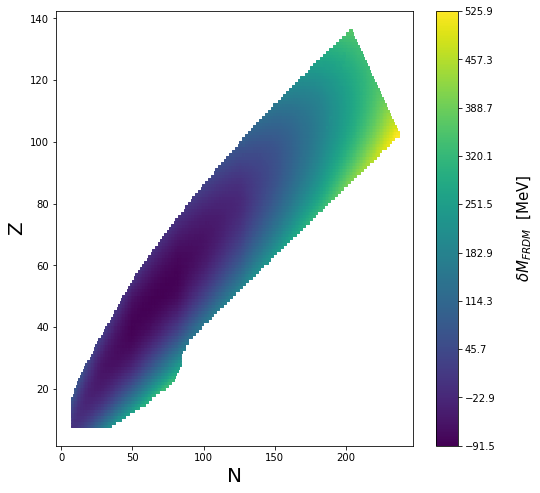

In [9]:
# Gráficas de N,Z vs deficit de mass
fig = plt.figure(figsize = (8,8))
#plt.scatter(np.concatenate((X11[:,2],XT[:,2])),np.concatenate((X11[:,1],XT[:,1])), c = np.concatenate((Y11,YT)), marker=',', s=7)
plt.scatter(XTNN[:,2],XTNN[:,1], c = YTNN, marker=',', s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)

#Argumento de plt.colorbar: format=ticker.FuncFormatter(fmt)
plt.colorbar(ticks=np.linspace(min(YTNN),max(YTNN),10)).set_label(label='$\delta M_{FRDM}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11Tv3.png',dpi = 500)
plt.show()

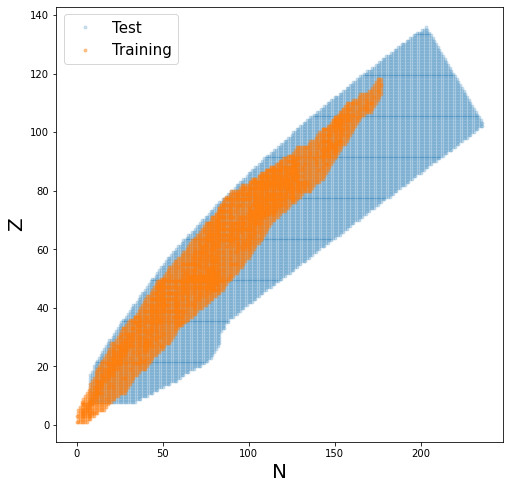

In [12]:
fig = plt.figure(figsize = (8,8))
plt.plot(XTNN[:,2],XTNN[:,1], '.', label = 'Test', alpha = 0.2)
plt.plot(X11NN[:,2],X11NN[:,1], '.', label = 'Training', alpha = 0.4)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.legend(fontsize=15)
plt.savefig('M11TTv3.png',dpi = 500)
plt.show()

# Modelo de Random Forest

# M12

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [26]:
# GridSearch
model12 = RandomForestRegressor()
hyperparam = {'n_estimators':[2000,1000]}
fitter = GridSearchCV(model12, hyperparam)

In [27]:
Y12TR1 = Y12TR.reshape(np.shape(X12TR)[0],)
fitter.fit(X12TR,Y12TR1)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [2000, 1000]})

In [28]:
fitter.best_params_

{'n_estimators': 1000}

In [29]:
# Se entrena el modelo
model12 = RandomForestRegressor(n_estimators= 2000)
Y12TR1 = Y12TR.reshape(np.shape(X12TR)[0],)
model12.fit(X12TR,Y12TR1)

RandomForestRegressor(n_estimators=2000)

In [30]:
print("Coeficiente de determinación del modelo para los datos de training: ",model12.score(X12TR, Y12TR))
print("Coeficiente de determinación del modelo para los datos de test: ",model12.score(X12TE, Y12TE))

Coeficiente de determinación del modelo para los datos de training:  0.9991318231008542
Coeficiente de determinación del modelo para los datos de test:  0.9928507264558859


In [32]:
FULLDATA12 = np.concatenate((X12TR,X12TE))
FULLDATAY = np.concatenate((Y12TR,Y12TE))
FULLDATA12NN = np.concatenate((X12TRNN,X12TENN))
FULLDATAYNN = np.concatenate((Y12TRNN,Y12TENN))
FULLDATAY = FULLDATAY.reshape(2191,)
PRED = model12.predict(FULLDATA12)

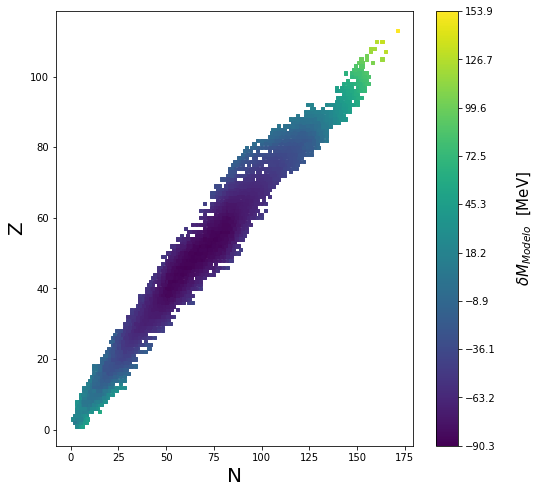

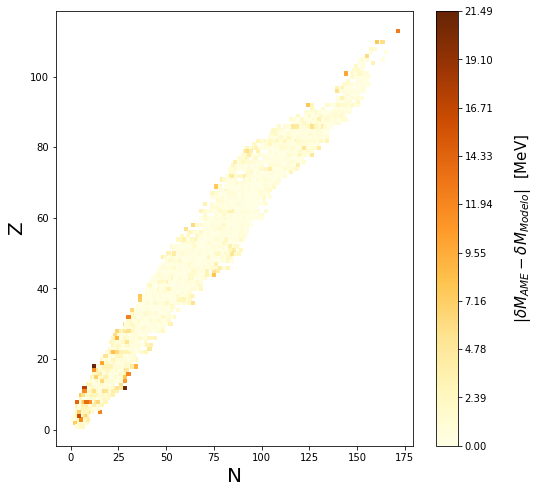

In [38]:
# Predicciones del modelo

RF12 = (maxY12 - minY12)*PRED + minY12

fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12NN[:,2],FULLDATA12NN[:,1], c = RF12, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(RF12),max(RF12),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M12RFPRED.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12NN[:,2],FULLDATA12NN[:,1], c = abs(RF12-FULLDATAYNN), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(RF12-FULLDATAYNN)),max(abs(RF12-FULLDATAYNN)),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M12RFDIFF.png',dpi = 500)
plt.show()

In [39]:
print("RMS del modelo: ", RMS(RF12,FULLDATAYNN), 'MeV')

RMS del modelo:  1.955580910196255 MeV


# M11

In [40]:
# GridSearch
model11 = RandomForestRegressor()
hyperparam = {'n_estimators':[3000,2000]}
fitter = GridSearchCV(model11, hyperparam)

In [41]:
Y11= Y11.reshape(np.shape(X11)[0],)
fitter.fit(X11,Y11)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [3000, 2000]})

In [42]:
fitter.best_params_

{'n_estimators': 3000}

In [43]:
# Se entrena el modelo
model11 = RandomForestRegressor(n_estimators= 3000)
Y11 = Y11.reshape(np.shape(X11)[0],)
model11.fit(X11,Y11)

RandomForestRegressor(n_estimators=3000)

In [44]:
print("Coeficiente de determinación del modelo para los datos de training: ",model11.score(X11, Y11))
print("Coeficiente de determinación del modelo para los datos de test: ",model11.score(XT, YT))

Coeficiente de determinación del modelo para los datos de training:  0.9992226474644624
Coeficiente de determinación del modelo para los datos de test:  0.5507014808053613


In [47]:
PRED11 = model11.predict(X11)
PREDFRDM = model11.predict(XT)

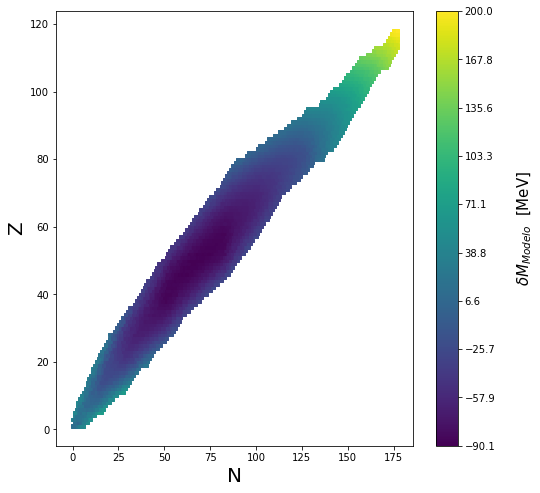

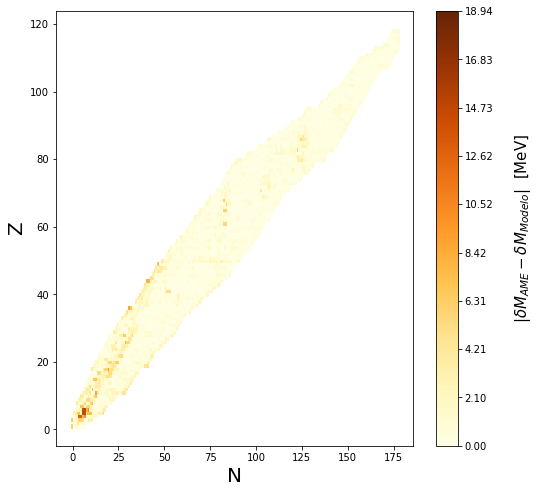

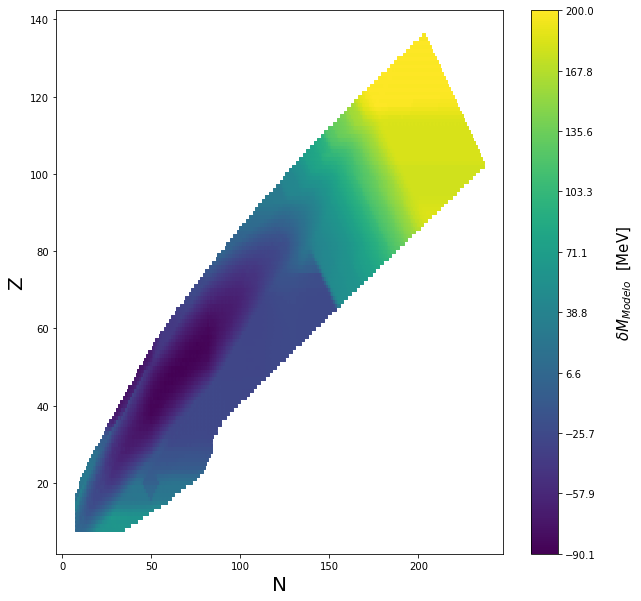

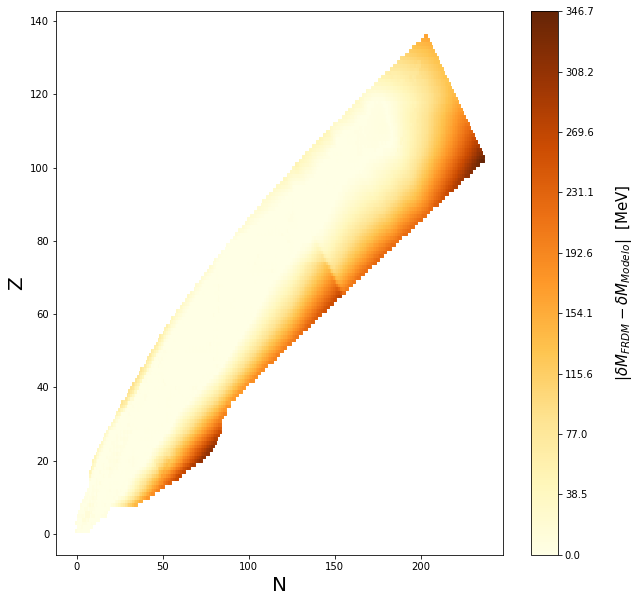

In [48]:
# Predicciones del modelo

RF11 = (maxY11 - minY11)*PRED11 + minY11
RF11T = (maxY11 - minY11)*PREDFRDM + minY11

fig = plt.figure(figsize = (8,8))
plt.scatter(X11NN[:,2],X11NN[:,1], c = RF11, s = 10, marker=',')
#plt.scatter(XT[:,2],XT[:,1], c = PREDFRDM, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(RF11),max(RF11),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFPRED.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(X11NN[:,2], X11NN[:,1], c = abs(RF11-Y11NN), s = 10, marker=',', cmap = 'YlOrBr')
#plt.scatter(np.concatenate((X11[:,2],XT[:,2])),np.concatenate((X11[:,1],XT[:,1])), c = abs(np.concatenate((PRED11,PREDFRDM))-np.concatenate((Y11,YT))), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(RF11-Y11NN)),max(abs(RF11-Y11NN)),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFDIFF.png',dpi = 500)
plt.show()


# Predicciones del modelo
fig = plt.figure(figsize = (10,10))
plt.scatter(XTNN[:,2],XTNN[:,1], c = RF11T, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(RF11T),max(RF11T),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFPREDv3.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (10,10))
plt.scatter(np.concatenate((X11NN[:,2],XTNN[:,2])),np.concatenate((X11NN[:,1],XTNN[:,1])), c = abs(np.concatenate((RF11,RF11T))-np.concatenate((Y11NN,YTNN))), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(np.concatenate((RF11,RF11T))-np.concatenate((Y11NN,YTNN)))),max(abs(np.concatenate((RF11,RF11T))-np.concatenate((Y11NN,YTNN)))),10)).set_label(label='|$\delta M_{FRDM}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFDIFFv3.png',dpi = 500)
plt.show()

# Extrapolación

In [49]:
# Se quitan los valores de FRDM en los datos de training 
Z11_TRUNC =  np.array(XT[:,1])
N11_TRUNC = np.array(XT[:,2])
PREDFRDM_TRUNC = np.array(PREDFRDM)
YT_TRUNC = YT 
        
for i in range(0,len(X11[:,2])):
    for j in range(0,len(N11_TRUNC)):
        
        if (X11[i,2] == N11_TRUNC[j]):
            if (X11[i,1] == Z11_TRUNC[j]):
                
                Z11_TRUNC = np.delete(Z11_TRUNC, j)
                N11_TRUNC = np.delete(N11_TRUNC, j)
                PREDFRDM_TRUNC = np.delete(PREDFRDM_TRUNC, j)
                YT_TRUNC = np.delete(YT_TRUNC, j)
                break

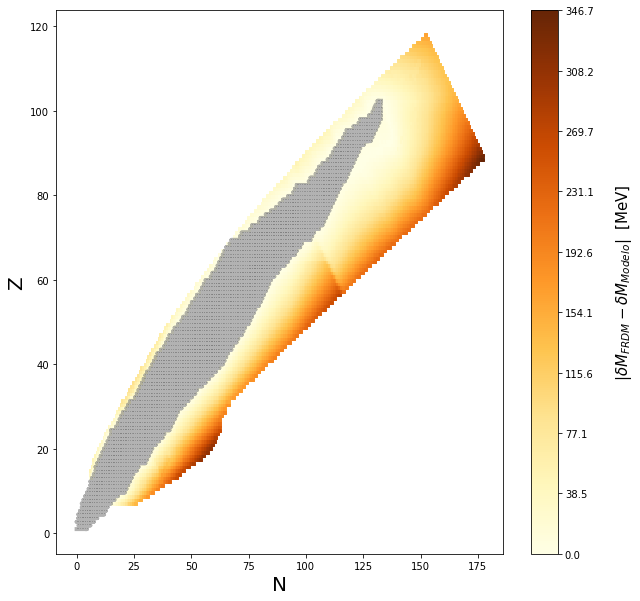

In [61]:
# Diferencias
diff = abs((maxY11 - minY11)*PREDFRDM_TRUNC - (maxY11 - minY11)*YT_TRUNC)


fig = plt.figure(figsize = (10,10))
plt.scatter((max(X11NN[:,2])-min(X11NN[:,2]))*N11_TRUNC+min(X11NN[:,2]), (max(X11NN[:,1])-min(X11NN[:,1]))*Z11_TRUNC+min(X11NN[:,1]), c = diff, s = 10, marker=',', cmap = 'YlOrBr')
plt.plot((max(X11NN[:,2])-min(X11NN[:,2]))*X11[:,2]+min(X11NN[:,2]), (max(X11NN[:,1])-min(X11NN[:,1]))*X11[:,1]+min(X11NN[:,1]), color ='grey', marker=',', linewidth=4, alpha = 0.6)

#plt.scatter((max(X11NN[:,2])-min(X11NN[:,2]))*N11_TRUNC + min(X11NN[:,2]), (max(X11NN[:,1])-min(X11NN[:,1]))*Z11_TRUNC+min(X11NN[:,1]), c = diff, s = 10, marker=',', cmap = 'YlOrBr')
#plt.plot(X11[:,2], X11[:,1], color ='grey', marker=',', linewidth=4, alpha = 0.6)

plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(diff),max(diff),10)).set_label(label='|$\delta M_{FRDM}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFDIFF_TRUNCv3.png',dpi = 500)
plt.show()

In [64]:
print("RMS del modelo: ", RMS(RF11 ,Y11NN), 'MeV')

RMS del modelo:  1.5104496362763886 MeV


# Modelo de Mixture Density Network (MDN)

### M12

In [4]:
import tensorflow as tf
from tensorflow import keras
import mdn

In [23]:
# Modelo de mixture density network
N_HIDDEN = 6  # number of hidden units in the Dense layer
N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = 1  # number of real-values predicted by each mixture component

model12 = keras.Sequential()
model12.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 12), activation='tanh'))
model12.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model12.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam( learning_rate=0.001))
model12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 78        
                                                                 
 mdn (MDN)                   (None, 3)                 21        
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model12.fit(x=X12TR, y=Y12TR, batch_size=128, epochs = 5000, validation_data=(X12TE, Y12TE))

Epoch 1/5000
14/14 [==============================] - 2s 30ms/step - loss: 0.9973 - val_loss: 0.9163
Epoch 2/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.8466 - val_loss: 0.7621
Epoch 3/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.6898 - val_loss: 0.6065
Epoch 4/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.5357 - val_loss: 0.4568
Epoch 5/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.3901 - val_loss: 0.3180
Epoch 6/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.2572 - val_loss: 0.1917
Epoch 7/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.1372 - val_loss: 0.0791
Epoch 8/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0306 - val_loss: -0.0205
Epoch 9/5000
14/14 [==============================] - 0s 5ms/step - loss: -0.0637 - val_loss: -0.1151
Epoch 10/5000
14/14 [==============================] - 0s 5ms/step - loss: -0.1492 - val_loss: -

Epoch 81/5000
14/14 [==============================] - 0s 5ms/step - loss: -2.0137 - val_loss: -2.0559
Epoch 82/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.0335 - val_loss: -2.0675
Epoch 83/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.0565 - val_loss: -2.0566
Epoch 84/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.0794 - val_loss: -2.0453
Epoch 85/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.0568 - val_loss: -2.0997
Epoch 86/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.0780 - val_loss: -2.1223
Epoch 87/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.1274 - val_loss: -2.1527
Epoch 88/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.1419 - val_loss: -2.1615
Epoch 89/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.1579 - val_loss: -2.1846
Epoch 90/5000
14/14 [==============================] - 0s 4ms/step - loss

Epoch 160/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.8368 - val_loss: -2.8924
Epoch 161/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.8669 - val_loss: -2.8714
Epoch 162/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.8903 - val_loss: -2.8967
Epoch 163/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.8998 - val_loss: -2.8684
Epoch 164/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.8821 - val_loss: -2.9322
Epoch 165/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.9164 - val_loss: -2.9223
Epoch 166/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.9089 - val_loss: -2.8977
Epoch 167/5000
14/14 [==============================] - 0s 4ms/step - loss: -2.9113 - val_loss: -2.8873
Epoch 168/5000
14/14 [==============================] - 0s 5ms/step - loss: -2.9257 - val_loss: -2.9470
Epoch 169/5000
14/14 [==============================] - 0s 5ms/s

Epoch 239/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.1775 - val_loss: -3.1335
Epoch 240/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.2104 - val_loss: -3.1870
Epoch 241/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.1383 - val_loss: -3.1944
Epoch 242/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.2001 - val_loss: -3.1984
Epoch 243/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.2356 - val_loss: -3.2044
Epoch 244/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.1932 - val_loss: -3.1777
Epoch 245/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.1954 - val_loss: -3.1335
Epoch 246/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.1795 - val_loss: -3.1713
Epoch 247/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.2182 - val_loss: -3.1823
Epoch 248/5000
14/14 [==============================] - 0s 4ms/s

Epoch 318/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3303 - val_loss: -3.3119
Epoch 319/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3365 - val_loss: -3.3040
Epoch 320/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.2730 - val_loss: -3.1855
Epoch 321/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.2810 - val_loss: -3.2803
Epoch 322/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.2729 - val_loss: -3.2906
Epoch 323/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3128 - val_loss: -3.3199
Epoch 324/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3323 - val_loss: -3.3014
Epoch 325/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3281 - val_loss: -3.2710
Epoch 326/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3166 - val_loss: -3.2737
Epoch 327/5000
14/14 [==============================] - 0s 4ms/s

Epoch 397/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3248 - val_loss: -3.2160
Epoch 398/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.2992 - val_loss: -3.3565
Epoch 399/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3807 - val_loss: -3.3677
Epoch 400/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3301 - val_loss: -3.3357
Epoch 401/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3446 - val_loss: -3.3496
Epoch 402/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3768 - val_loss: -3.3787
Epoch 403/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3842 - val_loss: -3.3354
Epoch 404/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3718 - val_loss: -3.3777
Epoch 405/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3925 - val_loss: -3.3750
Epoch 406/5000
14/14 [==============================] - 0s 4ms/s

Epoch 476/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3812 - val_loss: -3.3935
Epoch 477/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4080 - val_loss: -3.3697
Epoch 478/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3529 - val_loss: -3.4159
Epoch 479/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4005 - val_loss: -3.3673
Epoch 480/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4166 - val_loss: -3.4157
Epoch 481/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4126 - val_loss: -3.3634
Epoch 482/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3866 - val_loss: -3.3967
Epoch 483/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3971 - val_loss: -3.3982
Epoch 484/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4197 - val_loss: -3.4237
Epoch 485/5000
14/14 [==============================] - 0s 4ms/s

Epoch 555/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4413 - val_loss: -3.4433
Epoch 556/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4130 - val_loss: -3.4132
Epoch 557/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4150 - val_loss: -3.4473
Epoch 558/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3690 - val_loss: -3.2264
Epoch 559/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3586 - val_loss: -3.4371
Epoch 560/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4401 - val_loss: -3.4463
Epoch 561/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4373 - val_loss: -3.3457
Epoch 562/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3794 - val_loss: -3.3993
Epoch 563/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4361 - val_loss: -3.4381
Epoch 564/5000
14/14 [==============================] - 0s 5ms/s

Epoch 634/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4572 - val_loss: -3.3837
Epoch 635/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3618 - val_loss: -3.4210
Epoch 636/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3635 - val_loss: -3.4498
Epoch 637/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4242 - val_loss: -3.4306
Epoch 638/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4462 - val_loss: -3.4009
Epoch 639/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4468 - val_loss: -3.4405
Epoch 640/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4404 - val_loss: -3.4459
Epoch 641/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4431 - val_loss: -3.4661
Epoch 642/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4266 - val_loss: -3.3528
Epoch 643/5000
14/14 [==============================] - 0s 4ms/s

Epoch 713/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4488 - val_loss: -3.4374
Epoch 714/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4456 - val_loss: -3.4704
Epoch 715/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4398 - val_loss: -3.3961
Epoch 716/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3805 - val_loss: -3.3783
Epoch 717/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3003 - val_loss: -3.2617
Epoch 718/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3561 - val_loss: -3.4118
Epoch 719/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4273 - val_loss: -3.3882
Epoch 720/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3636 - val_loss: -3.4469
Epoch 721/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4529 - val_loss: -3.4635
Epoch 722/5000
14/14 [==============================] - 0s 4ms/s

Epoch 792/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3980 - val_loss: -3.4658
Epoch 793/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4088 - val_loss: -3.4591
Epoch 794/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4494 - val_loss: -3.3877
Epoch 795/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4509 - val_loss: -3.4446
Epoch 796/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4074 - val_loss: -3.4655
Epoch 797/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4501 - val_loss: -3.4459
Epoch 798/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4444 - val_loss: -3.4854
Epoch 799/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4762 - val_loss: -3.4910
Epoch 800/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4624 - val_loss: -3.4901
Epoch 801/5000
14/14 [==============================] - 0s 4ms/s

Epoch 871/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4352 - val_loss: -3.4953
Epoch 872/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4516 - val_loss: -3.4965
Epoch 873/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4877 - val_loss: -3.5032
Epoch 874/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4836 - val_loss: -3.5007
Epoch 875/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4989 - val_loss: -3.5066
Epoch 876/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4826 - val_loss: -3.4869
Epoch 877/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4781 - val_loss: -3.4300
Epoch 878/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4575 - val_loss: -3.5041
Epoch 879/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4889 - val_loss: -3.4513
Epoch 880/5000
14/14 [==============================] - 0s 5ms/s

Epoch 950/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4763 - val_loss: -3.4259
Epoch 951/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4383 - val_loss: -3.4739
Epoch 952/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4871 - val_loss: -3.4929
Epoch 953/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4804 - val_loss: -3.3974
Epoch 954/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3380 - val_loss: -3.5037
Epoch 955/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4611 - val_loss: -3.4126
Epoch 956/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4578 - val_loss: -3.4316
Epoch 957/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3714 - val_loss: -3.5031
Epoch 958/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4271 - val_loss: -3.5046
Epoch 959/5000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 4ms/step - loss: -3.4693 - val_loss: -3.3919
Epoch 1107/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4759 - val_loss: -3.5159
Epoch 1108/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5143 - val_loss: -3.5273
Epoch 1109/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5106 - val_loss: -3.5275
Epoch 1110/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5110 - val_loss: -3.5233
Epoch 1111/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4918 - val_loss: -3.5219
Epoch 1112/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4990 - val_loss: -3.3947
Epoch 1113/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4258 - val_loss: -3.3168
Epoch 1114/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4539 - val_loss: -3.5202
Epoch 1115/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 4ms/step - loss: -3.4715 - val_loss: -3.5445
Epoch 1263/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5288 - val_loss: -3.5328
Epoch 1264/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5063 - val_loss: -3.4251
Epoch 1265/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4280 - val_loss: -3.3817
Epoch 1266/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.3657 - val_loss: -3.4074
Epoch 1267/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3684 - val_loss: -3.3963
Epoch 1268/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4718 - val_loss: -3.4937
Epoch 1269/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4974 - val_loss: -3.5362
Epoch 1270/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5215 - val_loss: -3.5240
Epoch 1271/5000
14/14 [==============================] - 0s 4ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5184 - val_loss: -3.5481
Epoch 1419/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5106 - val_loss: -3.5329
Epoch 1420/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5203 - val_loss: -3.5154
Epoch 1421/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4786 - val_loss: -3.4757
Epoch 1422/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4502 - val_loss: -3.4887
Epoch 1423/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4630 - val_loss: -3.4500
Epoch 1424/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5051 - val_loss: -3.5080
Epoch 1425/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4984 - val_loss: -3.4664
Epoch 1426/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4670 - val_loss: -3.4418
Epoch 1427/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 4ms/step - loss: -3.5209 - val_loss: -3.5020
Epoch 1575/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4798 - val_loss: -3.4786
Epoch 1576/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4996 - val_loss: -3.5266
Epoch 1577/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5197 - val_loss: -3.5543
Epoch 1578/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5111 - val_loss: -3.5215
Epoch 1579/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4992 - val_loss: -3.5597
Epoch 1580/5000
14/14 [==============================] - 0s 6ms/step - loss: -3.5375 - val_loss: -3.5630
Epoch 1581/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4647 - val_loss: -3.5232
Epoch 1582/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4869 - val_loss: -3.5605
Epoch 1583/5000
14/14 [==============================] - 0s 4ms/step - 

14/14 [==============================] - 0s 4ms/step - loss: -3.4702 - val_loss: -3.5224
Epoch 1731/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4871 - val_loss: -3.5617
Epoch 1732/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5366 - val_loss: -3.4193
Epoch 1733/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5036 - val_loss: -3.5506
Epoch 1734/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5348 - val_loss: -3.4779
Epoch 1735/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5337 - val_loss: -3.5635
Epoch 1736/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5278 - val_loss: -3.5679
Epoch 1737/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5319 - val_loss: -3.5228
Epoch 1738/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5242 - val_loss: -3.5288
Epoch 1739/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5335 - val_loss: -3.5279
Epoch 1887/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4881 - val_loss: -3.4818
Epoch 1888/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5237 - val_loss: -3.5738
Epoch 1889/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5376 - val_loss: -3.5737
Epoch 1890/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5428 - val_loss: -3.5754
Epoch 1891/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5359 - val_loss: -3.5341
Epoch 1892/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5402 - val_loss: -3.5774
Epoch 1893/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5482 - val_loss: -3.5731
Epoch 1894/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5233 - val_loss: -3.5787
Epoch 1895/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5524 - val_loss: -3.5846
Epoch 2043/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5546 - val_loss: -3.5207
Epoch 2044/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4872 - val_loss: -3.5847
Epoch 2045/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5136 - val_loss: -3.5130
Epoch 2046/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5142 - val_loss: -3.4595
Epoch 2047/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4388 - val_loss: -3.4979
Epoch 2048/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4941 - val_loss: -3.5372
Epoch 2049/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5284 - val_loss: -3.5743
Epoch 2050/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4975 - val_loss: -3.4391
Epoch 2051/5000
14/14 [==============================] - 0s 4ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5312 - val_loss: -3.5542
Epoch 2199/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5307 - val_loss: -3.5084
Epoch 2200/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5465 - val_loss: -3.5493
Epoch 2201/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5571 - val_loss: -3.5755
Epoch 2202/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5327 - val_loss: -3.5824
Epoch 2203/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5414 - val_loss: -3.5619
Epoch 2204/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5036 - val_loss: -3.5455
Epoch 2205/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5053 - val_loss: -3.5593
Epoch 2206/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5453 - val_loss: -3.5835
Epoch 2207/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.4659 - val_loss: -3.5490
Epoch 2355/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4344 - val_loss: -3.4436
Epoch 2356/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5346 - val_loss: -3.5727
Epoch 2357/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5434 - val_loss: -3.5546
Epoch 2358/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5304 - val_loss: -3.5919
Epoch 2359/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5516 - val_loss: -3.5885
Epoch 2360/5000
14/14 [==============================] - 0s 6ms/step - loss: -3.5396 - val_loss: -3.5774
Epoch 2361/5000
14/14 [==============================] - 0s 7ms/step - loss: -3.5615 - val_loss: -3.5492
Epoch 2362/5000
14/14 [==============================] - 0s 6ms/step - loss: -3.5364 - val_loss: -3.4103
Epoch 2363/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.4253 - val_loss: -3.4307
Epoch 2511/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4924 - val_loss: -3.4195
Epoch 2512/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4797 - val_loss: -3.5536
Epoch 2513/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5222 - val_loss: -3.5726
Epoch 2514/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5422 - val_loss: -3.5153
Epoch 2515/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5191 - val_loss: -3.5942
Epoch 2516/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5268 - val_loss: -3.5479
Epoch 2517/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5294 - val_loss: -3.5183
Epoch 2518/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5535 - val_loss: -3.5524
Epoch 2519/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.4699 - val_loss: -3.5310
Epoch 2667/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5504 - val_loss: -3.6015
Epoch 2668/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5700 - val_loss: -3.5934
Epoch 2669/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5397 - val_loss: -3.4838
Epoch 2670/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5133 - val_loss: -3.5034
Epoch 2671/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5510 - val_loss: -3.5937
Epoch 2672/5000
14/14 [==============================] - 0s 6ms/step - loss: -3.5664 - val_loss: -3.5726
Epoch 2673/5000
14/14 [==============================] - 0s 6ms/step - loss: -3.5603 - val_loss: -3.5564
Epoch 2674/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5544 - val_loss: -3.5871
Epoch 2675/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5168 - val_loss: -3.5431
Epoch 2823/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5599 - val_loss: -3.6057
Epoch 2824/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5594 - val_loss: -3.5909
Epoch 2825/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5253 - val_loss: -3.5879
Epoch 2826/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5621 - val_loss: -3.6060
Epoch 2827/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5666 - val_loss: -3.6015
Epoch 2828/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5587 - val_loss: -3.6075
Epoch 2829/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5629 - val_loss: -3.5992
Epoch 2830/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5571 - val_loss: -3.4314
Epoch 2831/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5494 - val_loss: -3.5758
Epoch 2979/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5575 - val_loss: -3.6113
Epoch 2980/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5483 - val_loss: -3.4753
Epoch 2981/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3938 - val_loss: -3.5217
Epoch 2982/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5144 - val_loss: -3.5967
Epoch 2983/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5684 - val_loss: -3.5539
Epoch 2984/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5657 - val_loss: -3.6084
Epoch 2985/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5323 - val_loss: -3.5999
Epoch 2986/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5728 - val_loss: -3.4997
Epoch 2987/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5403 - val_loss: -3.5884
Epoch 3135/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5697 - val_loss: -3.6142
Epoch 3136/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5350 - val_loss: -3.6085
Epoch 3137/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5603 - val_loss: -3.6098
Epoch 3138/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4815 - val_loss: -3.1810
Epoch 3139/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4484 - val_loss: -3.5953
Epoch 3140/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5390 - val_loss: -3.5260
Epoch 3141/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4910 - val_loss: -3.5948
Epoch 3142/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5701 - val_loss: -3.5922
Epoch 3143/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5131 - val_loss: -3.4459
Epoch 3291/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5079 - val_loss: -3.5654
Epoch 3292/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5544 - val_loss: -3.6109
Epoch 3293/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5639 - val_loss: -3.6142
Epoch 3294/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5794 - val_loss: -3.5859
Epoch 3295/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5497 - val_loss: -3.5947
Epoch 3296/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5682 - val_loss: -3.6107
Epoch 3297/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5779 - val_loss: -3.6126
Epoch 3298/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5570 - val_loss: -3.5475
Epoch 3299/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5403 - val_loss: -3.4076
Epoch 3447/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4878 - val_loss: -3.4172
Epoch 3448/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5351 - val_loss: -3.6093
Epoch 3449/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5673 - val_loss: -3.5985
Epoch 3450/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5668 - val_loss: -3.5997
Epoch 3451/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5552 - val_loss: -3.6040
Epoch 3452/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5411 - val_loss: -3.6128
Epoch 3453/5000
14/14 [==============================] - 0s 6ms/step - loss: -3.5664 - val_loss: -3.5991
Epoch 3454/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5226 - val_loss: -3.6043
Epoch 3455/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5776 - val_loss: -3.5909
Epoch 3603/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5716 - val_loss: -3.6065
Epoch 3604/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5862 - val_loss: -3.6238
Epoch 3605/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5804 - val_loss: -3.4241
Epoch 3606/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5539 - val_loss: -3.4512
Epoch 3607/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5547 - val_loss: -3.5734
Epoch 3608/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5578 - val_loss: -3.6201
Epoch 3609/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5796 - val_loss: -3.6100
Epoch 3610/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5667 - val_loss: -3.5653
Epoch 3611/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5734 - val_loss: -3.6223
Epoch 3759/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5743 - val_loss: -3.6008
Epoch 3760/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5680 - val_loss: -3.5931
Epoch 3761/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5350 - val_loss: -3.4689
Epoch 3762/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4312 - val_loss: -3.5492
Epoch 3763/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4841 - val_loss: -3.5921
Epoch 3764/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5742 - val_loss: -3.6071
Epoch 3765/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5636 - val_loss: -3.6259
Epoch 3766/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5480 - val_loss: -3.5884
Epoch 3767/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5653 - val_loss: -3.6146
Epoch 3915/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5907 - val_loss: -3.6146
Epoch 3916/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5790 - val_loss: -3.6157
Epoch 3917/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5639 - val_loss: -3.4796
Epoch 3918/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5441 - val_loss: -3.6151
Epoch 3919/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5752 - val_loss: -3.6186
Epoch 3920/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5638 - val_loss: -3.6030
Epoch 3921/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5836 - val_loss: -3.6112
Epoch 3922/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5832 - val_loss: -3.6294
Epoch 3923/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5718 - val_loss: -3.5644
Epoch 4071/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4961 - val_loss: -3.4230
Epoch 4072/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.4825 - val_loss: -3.6178
Epoch 4073/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5698 - val_loss: -3.6242
Epoch 4074/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5820 - val_loss: -3.6186
Epoch 4075/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5736 - val_loss: -3.6281
Epoch 4076/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5873 - val_loss: -3.6100
Epoch 4077/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5672 - val_loss: -3.6215
Epoch 4078/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5161 - val_loss: -3.6345
Epoch 4079/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5842 - val_loss: -3.6294
Epoch 4227/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5692 - val_loss: -3.6293
Epoch 4228/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5492 - val_loss: -3.6289
Epoch 4229/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5849 - val_loss: -3.6295
Epoch 4230/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5759 - val_loss: -3.4855
Epoch 4231/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5205 - val_loss: -3.5537
Epoch 4232/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5746 - val_loss: -3.6144
Epoch 4233/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5921 - val_loss: -3.6324
Epoch 4234/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5922 - val_loss: -3.6291
Epoch 4235/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5684 - val_loss: -3.6360
Epoch 4383/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5811 - val_loss: -3.5075
Epoch 4384/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5671 - val_loss: -3.5708
Epoch 4385/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.3847 - val_loss: -3.5968
Epoch 4386/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.4621 - val_loss: -3.5540
Epoch 4387/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5098 - val_loss: -3.5256
Epoch 4388/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5646 - val_loss: -3.6147
Epoch 4389/5000
14/14 [==============================] - 0s 4ms/step - loss: -3.5561 - val_loss: -3.6030
Epoch 4390/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5589 - val_loss: -3.6269
Epoch 4391/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5765 - val_loss: -3.6378
Epoch 4539/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.6054 - val_loss: -3.5616
Epoch 4540/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5649 - val_loss: -3.6389
Epoch 4541/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5528 - val_loss: -3.5958
Epoch 4542/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5474 - val_loss: -3.5684
Epoch 4543/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5687 - val_loss: -3.6311
Epoch 4544/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5023 - val_loss: -3.6165
Epoch 4545/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5523 - val_loss: -3.6304
Epoch 4546/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5680 - val_loss: -3.6159
Epoch 4547/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 4ms/step - loss: -3.5704 - val_loss: -3.6167
Epoch 4695/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.6005 - val_loss: -3.6376
Epoch 4696/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5875 - val_loss: -3.6375
Epoch 4697/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5725 - val_loss: -3.6360
Epoch 4698/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5826 - val_loss: -3.6463
Epoch 4699/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5143 - val_loss: -3.6359
Epoch 4700/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5470 - val_loss: -3.5793
Epoch 4701/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5966 - val_loss: -3.6160
Epoch 4702/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.6000 - val_loss: -3.6361
Epoch 4703/5000
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: -3.5992 - val_loss: -3.6413
Epoch 4851/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.6013 - val_loss: -3.6362
Epoch 4852/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5949 - val_loss: -3.6378
Epoch 4853/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5955 - val_loss: -3.6426
Epoch 4854/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5609 - val_loss: -3.3951
Epoch 4855/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5125 - val_loss: -3.6230
Epoch 4856/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.5694 - val_loss: -3.6244
Epoch 4857/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.6024 - val_loss: -3.6364
Epoch 4858/5000
14/14 [==============================] - 0s 5ms/step - loss: -3.6040 - val_loss: -3.6473
Epoch 4859/5000
14/14 [==============================] - 0s 5ms/step - 

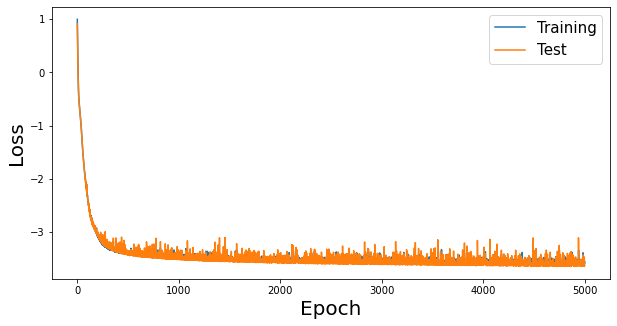

In [25]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,9])
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Test')

plt.xlabel('Epoch', fontsize= 20)
plt.ylabel('Loss', fontsize= 20)
plt.legend(fontsize=15)
#plt.yscale('log')

plt.savefig('LossvsEpoch.png',dpi = 500)
plt.show()

In [26]:
FULLDATA12NN = np.concatenate((X12TRNN,X12TENN))
FULLDATAYNN = np.concatenate((Y12TRNN,Y12TENN))

FULLDATA12 = np.concatenate((X12TR,X12TE))
FULLDATAY = np.concatenate((Y12TR,Y12TE))

In [27]:
# Predicción del modelo
y_test = model12.predict(FULLDATA12)
y_test

69/69 [==============================] - 0s 1ms/step


array([[ 0.28753483,  0.01291227,  0.1813189 ],
       [ 0.53428066,  0.00711709, -0.03007548],
       [ 0.10677868,  0.00663191,  0.03567426],
       ...,
       [ 0.08815831,  0.0069623 ,  0.015861  ],
       [ 0.02946401,  0.0056271 ,  0.25564867],
       [ 0.36827677,  0.00582224,  0.20540397]], dtype=float32)

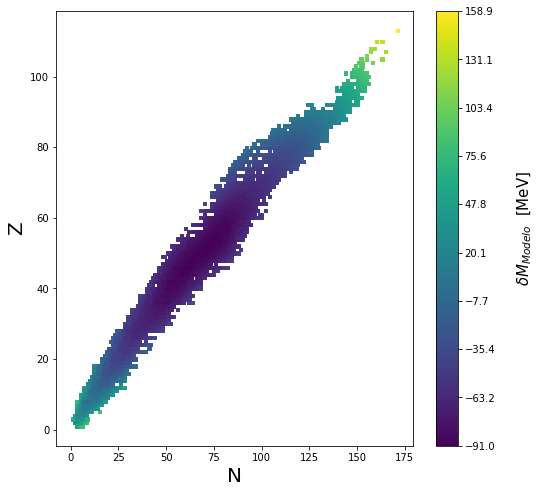

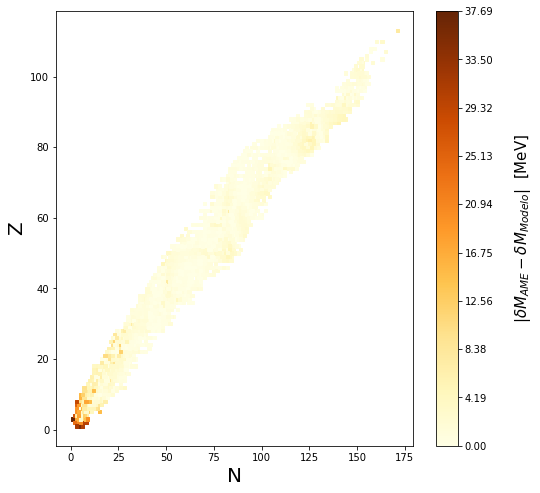

In [28]:
# Valores medios del modelo

# Predicciones del modelo

# Se "des-normalizan" las predicciones
C1 = (maxY12 - minY12)*y_test[:,0].reshape(2191,-1) + minY12
C2 = (maxY12 - minY12)*FULLDATAY.reshape(2191,-1) + minY12

fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12NN[:,2], FULLDATA12NN[:,1], c = C1, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(C1),max(C1),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M12MDNPREDmean.png',dpi = 500)
plt.show()

# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12NN[:,2],FULLDATA12NN[:,1], c = abs(C1-FULLDATAYNN.reshape(2191,-1)), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(C1-C2)),max(abs(C1-FULLDATAYNN.reshape(2191,-1))),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M12MDNDIFFmean.png',dpi = 500)
plt.show()

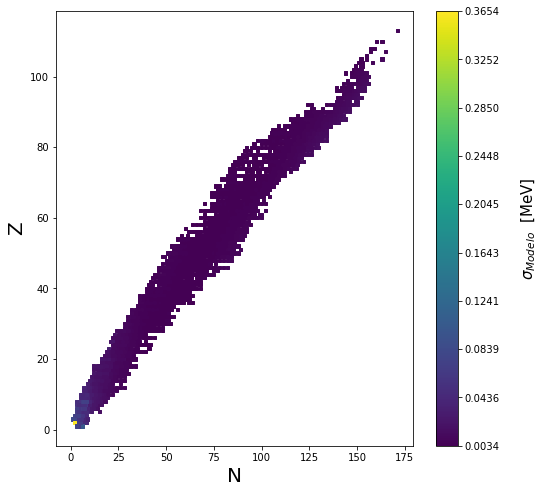

In [29]:
# Desviaciones estándar del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12NN[:,2],FULLDATA12NN[:,1], c = y_test[:,1].reshape(2191,-1), s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(y_test[:,1].reshape(2191,-1)),max(y_test[:,1].reshape(2191,-1)),10)).set_label(label='$\sigma_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M12MDNPREDsigma.png',dpi = 500)
plt.show()

In [30]:
print("RMS del modelo: ", RMS(C1,FULLDATAYNN.reshape(2191,-1))[0], 'MeV')

RMS del modelo:  3.5641250880482707 MeV


### M11

In [32]:
# Modelo de mixture density network
N_HIDDEN = 6  # number of hidden units in the Dense layer
N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = 1  # number of real-values predicted by each mixture component

model11 = keras.Sequential()
model11.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 11), activation='tanh'))
model11.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model11.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam( learning_rate=0.001))
model11.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 72        
                                                                 
 mdn_2 (MDN)                 (None, 3)                 21        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model11.fit(x=X11, y=Y11, batch_size=128, epochs=6000, validation_data=(X11, Y11))

Epoch 1/6000
46/46 [==============================] - 2s 11ms/step - loss: 1.0326 - val_loss: 0.7419
Epoch 2/6000
46/46 [==============================] - 0s 5ms/step - loss: 0.5155 - val_loss: 0.2679
Epoch 3/6000
46/46 [==============================] - 0s 5ms/step - loss: 0.0342 - val_loss: -0.2131
Epoch 4/6000
46/46 [==============================] - 0s 5ms/step - loss: -0.4322 - val_loss: -0.6556
Epoch 5/6000
46/46 [==============================] - 0s 5ms/step - loss: -0.8462 - val_loss: -1.0297
Epoch 6/6000
46/46 [==============================] - 0s 7ms/step - loss: -1.1522 - val_loss: -1.2530
Epoch 7/6000
46/46 [==============================] - 0s 5ms/step - loss: -1.3229 - val_loss: -1.3904
Epoch 8/6000
46/46 [==============================] - 0s 5ms/step - loss: -1.4337 - val_loss: -1.4958
Epoch 9/6000
46/46 [==============================] - 0s 5ms/step - loss: -1.5412 - val_loss: -1.5908
Epoch 10/6000
46/46 [==============================] - 0s 5ms/step - loss: -1.6389 - v

46/46 [==============================] - 0s 4ms/step - loss: -3.1731 - val_loss: -3.1905
Epoch 160/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.2088 - val_loss: -3.1639
Epoch 161/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.2146 - val_loss: -3.1331
Epoch 162/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.2139 - val_loss: -3.2501
Epoch 163/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.2286 - val_loss: -3.2019
Epoch 164/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.2348 - val_loss: -3.2547
Epoch 165/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.2511 - val_loss: -3.1747
Epoch 166/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.2173 - val_loss: -3.2229
Epoch 167/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.2561 - val_loss: -3.0951
Epoch 168/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.

Epoch 238/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.8875 - val_loss: -3.8512
Epoch 239/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.8703 - val_loss: -3.8800
Epoch 240/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.9072 - val_loss: -3.8896
Epoch 241/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.9008 - val_loss: -3.9400
Epoch 242/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.8679 - val_loss: -3.8889
Epoch 243/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.9103 - val_loss: -3.9429
Epoch 244/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.9251 - val_loss: -3.9323
Epoch 245/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.8693 - val_loss: -3.9391
Epoch 246/6000
46/46 [==============================] - 0s 4ms/step - loss: -3.8999 - val_loss: -3.9585
Epoch 247/6000
46/46 [==============================] - 0s 4ms/s

Epoch 317/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.0688 - val_loss: -4.0147
Epoch 318/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.0523 - val_loss: -4.0384
Epoch 319/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.0896 - val_loss: -4.1242
Epoch 320/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.0922 - val_loss: -4.1270
Epoch 321/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.0581 - val_loss: -4.0930
Epoch 322/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.0571 - val_loss: -4.1171
Epoch 323/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.0658 - val_loss: -4.1247
Epoch 324/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.0952 - val_loss: -4.0275
Epoch 325/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.0039 - val_loss: -4.1198
Epoch 326/6000
46/46 [==============================] - 0s 5ms/s

Epoch 396/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.0973 - val_loss: -4.0914
Epoch 397/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1520 - val_loss: -4.1604
Epoch 398/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1516 - val_loss: -3.9125
Epoch 399/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1367 - val_loss: -4.1437
Epoch 400/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.0941 - val_loss: -4.1398
Epoch 401/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.0737 - val_loss: -4.0602
Epoch 402/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1199 - val_loss: -4.1862
Epoch 403/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1683 - val_loss: -4.1815
Epoch 404/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1639 - val_loss: -4.2017
Epoch 405/6000
46/46 [==============================] - 0s 5ms/s

Epoch 475/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1988 - val_loss: -4.1955
Epoch 476/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.1897 - val_loss: -4.2132
Epoch 477/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.1699 - val_loss: -4.1596
Epoch 478/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.0603 - val_loss: -4.1502
Epoch 479/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2119 - val_loss: -4.2339
Epoch 480/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1714 - val_loss: -4.2428
Epoch 481/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1881 - val_loss: -3.6795
Epoch 482/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.1547 - val_loss: -4.2019
Epoch 483/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.1134 - val_loss: -4.0463
Epoch 484/6000
46/46 [==============================] - 0s 5ms/s

Epoch 554/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2013 - val_loss: -4.2820
Epoch 555/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2165 - val_loss: -4.2117
Epoch 556/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2126 - val_loss: -4.1252
Epoch 557/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2270 - val_loss: -4.2405
Epoch 558/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.1775 - val_loss: -4.2732
Epoch 559/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2576 - val_loss: -4.2904
Epoch 560/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2480 - val_loss: -4.2802
Epoch 561/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.0726 - val_loss: -4.2388
Epoch 562/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2492 - val_loss: -4.2672
Epoch 563/6000
46/46 [==============================] - 0s 4ms/s

Epoch 633/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2445 - val_loss: -4.3097
Epoch 634/6000
46/46 [==============================] - 0s 8ms/step - loss: -4.1770 - val_loss: -4.2988
Epoch 635/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.2493 - val_loss: -4.2658
Epoch 636/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2653 - val_loss: -4.2707
Epoch 637/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.1942 - val_loss: -4.2744
Epoch 638/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2520 - val_loss: -4.1789
Epoch 639/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2888 - val_loss: -4.2627
Epoch 640/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2307 - val_loss: -4.1151
Epoch 641/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2017 - val_loss: -4.3005
Epoch 642/6000
46/46 [==============================] - 0s 4ms/s

Epoch 712/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2368 - val_loss: -4.3207
Epoch 713/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.3046 - val_loss: -4.3324
Epoch 714/6000
46/46 [==============================] - 0s 7ms/step - loss: -4.2518 - val_loss: -4.0648
Epoch 715/6000
46/46 [==============================] - 0s 7ms/step - loss: -4.2710 - val_loss: -4.0038
Epoch 716/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2365 - val_loss: -4.0648
Epoch 717/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2748 - val_loss: -4.1903
Epoch 718/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.1993 - val_loss: -4.2354
Epoch 719/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2988 - val_loss: -4.3335
Epoch 720/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.3233 - val_loss: -4.3452
Epoch 721/6000
46/46 [==============================] - 0s 7ms/s

Epoch 791/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3304 - val_loss: -4.3171
Epoch 792/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3286 - val_loss: -4.3013
Epoch 793/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.1168 - val_loss: -4.3237
Epoch 794/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3121 - val_loss: -4.3278
Epoch 795/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3207 - val_loss: -4.2683
Epoch 796/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3068 - val_loss: -4.3321
Epoch 797/6000
46/46 [==============================] - 0s 7ms/step - loss: -4.3198 - val_loss: -4.3429
Epoch 798/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2644 - val_loss: -4.3049
Epoch 799/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3061 - val_loss: -4.3454
Epoch 800/6000
46/46 [==============================] - 0s 5ms/s

Epoch 870/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2787 - val_loss: -4.2949
Epoch 871/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3311 - val_loss: -4.3800
Epoch 872/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2491 - val_loss: -4.3100
Epoch 873/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3163 - val_loss: -4.0446
Epoch 874/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3436 - val_loss: -4.1379
Epoch 875/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3103 - val_loss: -4.2003
Epoch 876/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3171 - val_loss: -4.3828
Epoch 877/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3280 - val_loss: -3.1334
Epoch 878/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2717 - val_loss: -4.3638
Epoch 879/6000
46/46 [==============================] - 0s 4ms/s

Epoch 949/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3648 - val_loss: -4.4038
Epoch 950/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3412 - val_loss: -4.3865
Epoch 951/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.3213 - val_loss: -4.3999
Epoch 952/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2963 - val_loss: -4.2523
Epoch 953/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2958 - val_loss: -4.3652
Epoch 954/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.3572 - val_loss: -4.3910
Epoch 955/6000
46/46 [==============================] - 0s 7ms/step - loss: -4.3595 - val_loss: -4.2427
Epoch 956/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.3040 - val_loss: -4.3832
Epoch 957/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3870 - val_loss: -4.4125
Epoch 958/6000
46/46 [==============================] - 0s 4ms/s

46/46 [==============================] - 0s 4ms/step - loss: -4.3534 - val_loss: -4.1689
Epoch 1106/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3053 - val_loss: -4.2805
Epoch 1107/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3206 - val_loss: -4.3646
Epoch 1108/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3870 - val_loss: -4.4080
Epoch 1109/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.0805 - val_loss: -4.3828
Epoch 1110/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3540 - val_loss: -4.4061
Epoch 1111/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3850 - val_loss: -3.9677
Epoch 1112/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3532 - val_loss: -4.4083
Epoch 1113/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3581 - val_loss: -4.4109
Epoch 1114/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4220 - val_loss: -4.2854
Epoch 1262/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3247 - val_loss: -4.3305
Epoch 1263/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3558 - val_loss: -4.2826
Epoch 1264/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3477 - val_loss: -4.4234
Epoch 1265/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4042 - val_loss: -4.4635
Epoch 1266/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4195 - val_loss: -4.4091
Epoch 1267/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3655 - val_loss: -4.4562
Epoch 1268/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4293 - val_loss: -4.4037
Epoch 1269/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3518 - val_loss: -4.3342
Epoch 1270/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.3857 - val_loss: -4.4791
Epoch 1418/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3591 - val_loss: -4.2541
Epoch 1419/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3464 - val_loss: -4.4718
Epoch 1420/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4334 - val_loss: -4.4219
Epoch 1421/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.2245 - val_loss: -4.4552
Epoch 1422/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4378 - val_loss: -4.4746
Epoch 1423/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4193 - val_loss: -4.4835
Epoch 1424/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4514 - val_loss: -4.4537
Epoch 1425/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3925 - val_loss: -4.4740
Epoch 1426/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4612 - val_loss: -4.4874
Epoch 1574/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3672 - val_loss: -4.2806
Epoch 1575/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3515 - val_loss: -4.4731
Epoch 1576/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4794 - val_loss: -4.2751
Epoch 1577/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4486 - val_loss: -4.3875
Epoch 1578/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4315 - val_loss: -4.5118
Epoch 1579/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4889 - val_loss: -4.5095
Epoch 1580/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4224 - val_loss: -4.5134
Epoch 1581/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4541 - val_loss: -4.2874
Epoch 1582/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4524 - val_loss: -4.2479
Epoch 1730/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4409 - val_loss: -4.5228
Epoch 1731/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4754 - val_loss: -4.3750
Epoch 1732/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4504 - val_loss: -4.4858
Epoch 1733/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4956 - val_loss: -4.5262
Epoch 1734/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4750 - val_loss: -4.3534
Epoch 1735/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3115 - val_loss: -4.2911
Epoch 1736/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4472 - val_loss: -4.5248
Epoch 1737/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4612 - val_loss: -4.2907
Epoch 1738/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4757 - val_loss: -4.4058
Epoch 1886/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4496 - val_loss: -4.3239
Epoch 1887/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5207 - val_loss: -4.5374
Epoch 1888/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4589 - val_loss: -4.4718
Epoch 1889/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5049 - val_loss: -4.5459
Epoch 1890/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4711 - val_loss: -4.4959
Epoch 1891/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4459 - val_loss: -4.5428
Epoch 1892/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4751 - val_loss: -4.5471
Epoch 1893/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3486 - val_loss: -4.5126
Epoch 1894/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5151 - val_loss: -4.4509
Epoch 2042/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4945 - val_loss: -4.5554
Epoch 2043/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4992 - val_loss: -4.5565
Epoch 2044/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4465 - val_loss: -4.2982
Epoch 2045/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4340 - val_loss: -4.5295
Epoch 2046/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4511 - val_loss: -4.5127
Epoch 2047/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4810 - val_loss: -4.5614
Epoch 2048/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5205 - val_loss: -4.4163
Epoch 2049/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5099 - val_loss: -4.5061
Epoch 2050/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 5ms/step - loss: -4.4710 - val_loss: -4.5492
Epoch 2198/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5135 - val_loss: -4.5057
Epoch 2199/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3520 - val_loss: -4.4124
Epoch 2200/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3324 - val_loss: -4.4889
Epoch 2201/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.4337 - val_loss: -4.3135
Epoch 2202/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.5138 - val_loss: -4.5354
Epoch 2203/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.5049 - val_loss: -4.5819
Epoch 2204/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.4889 - val_loss: -4.5559
Epoch 2205/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3875 - val_loss: -4.4566
Epoch 2206/6000
46/46 [==============================] - 0s 5ms/step - 

46/46 [==============================] - 0s 5ms/step - loss: -4.5422 - val_loss: -4.4081
Epoch 2354/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5140 - val_loss: -4.4555
Epoch 2355/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4622 - val_loss: -4.5432
Epoch 2356/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.5600 - val_loss: -4.5887
Epoch 2357/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.5578 - val_loss: -4.5924
Epoch 2358/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.4723 - val_loss: -4.5132
Epoch 2359/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5212 - val_loss: -4.5517
Epoch 2360/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.4955 - val_loss: -4.1215
Epoch 2361/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.2953 - val_loss: -4.5460
Epoch 2362/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5138 - val_loss: -4.4840
Epoch 2510/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.3848 - val_loss: -3.9911
Epoch 2511/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.4188 - val_loss: -4.5292
Epoch 2512/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.4882 - val_loss: -4.5365
Epoch 2513/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5360 - val_loss: -4.5925
Epoch 2514/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5642 - val_loss: -4.5593
Epoch 2515/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5545 - val_loss: -4.5866
Epoch 2516/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5244 - val_loss: -4.5371
Epoch 2517/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5017 - val_loss: -4.5675
Epoch 2518/6000
46/46 [==============================] - 0s 5ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5539 - val_loss: -4.2504
Epoch 2666/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5177 - val_loss: -4.5202
Epoch 2667/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5496 - val_loss: -4.4964
Epoch 2668/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5333 - val_loss: -4.6094
Epoch 2669/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5478 - val_loss: -4.6151
Epoch 2670/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5779 - val_loss: -4.4724
Epoch 2671/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5502 - val_loss: -4.4664
Epoch 2672/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4802 - val_loss: -4.5602
Epoch 2673/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5731 - val_loss: -4.6200
Epoch 2674/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4578 - val_loss: -4.5819
Epoch 2822/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5781 - val_loss: -4.6089
Epoch 2823/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5292 - val_loss: -4.6012
Epoch 2824/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5151 - val_loss: -4.6012
Epoch 2825/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5870 - val_loss: -4.5948
Epoch 2826/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5606 - val_loss: -4.4653
Epoch 2827/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5441 - val_loss: -4.6096
Epoch 2828/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5174 - val_loss: -4.0921
Epoch 2829/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4997 - val_loss: -4.5974
Epoch 2830/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5554 - val_loss: -4.5899
Epoch 2978/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5911 - val_loss: -4.6150
Epoch 2979/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5734 - val_loss: -4.5704
Epoch 2980/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5305 - val_loss: -4.5345
Epoch 2981/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4873 - val_loss: -4.5750
Epoch 2982/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5579 - val_loss: -4.5938
Epoch 2983/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5750 - val_loss: -4.5689
Epoch 2984/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5078 - val_loss: -4.5783
Epoch 2985/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5326 - val_loss: -4.5143
Epoch 2986/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4443 - val_loss: -4.6119
Epoch 3134/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5445 - val_loss: -4.6247
Epoch 3135/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5680 - val_loss: -4.6171
Epoch 3136/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5658 - val_loss: -4.3662
Epoch 3137/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5524 - val_loss: -4.6085
Epoch 3138/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5745 - val_loss: -3.9928
Epoch 3139/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4636 - val_loss: -4.5145
Epoch 3140/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5739 - val_loss: -4.4084
Epoch 3141/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5698 - val_loss: -4.5085
Epoch 3142/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5796 - val_loss: -4.6186
Epoch 3290/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5311 - val_loss: -4.5703
Epoch 3291/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5823 - val_loss: -4.5561
Epoch 3292/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5320 - val_loss: -4.6019
Epoch 3293/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5888 - val_loss: -4.3515
Epoch 3294/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5690 - val_loss: -4.6216
Epoch 3295/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5493 - val_loss: -4.4907
Epoch 3296/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5039 - val_loss: -4.4816
Epoch 3297/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5005 - val_loss: -4.5986
Epoch 3298/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4176 - val_loss: -4.5495
Epoch 3446/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5276 - val_loss: -4.5968
Epoch 3447/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5785 - val_loss: -4.6351
Epoch 3448/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6244 - val_loss: -4.6098
Epoch 3449/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5865 - val_loss: -4.5173
Epoch 3450/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6137 - val_loss: -4.6273
Epoch 3451/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5955 - val_loss: -4.5928
Epoch 3452/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5644 - val_loss: -4.5983
Epoch 3453/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5431 - val_loss: -4.6360
Epoch 3454/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5609 - val_loss: -4.6299
Epoch 3602/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5996 - val_loss: -4.3045
Epoch 3603/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5768 - val_loss: -4.5376
Epoch 3604/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5213 - val_loss: -4.3964
Epoch 3605/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5016 - val_loss: -4.5346
Epoch 3606/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5725 - val_loss: -4.5688
Epoch 3607/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5742 - val_loss: -4.6241
Epoch 3608/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5924 - val_loss: -4.5450
Epoch 3609/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5911 - val_loss: -4.6046
Epoch 3610/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5953 - val_loss: -4.5953
Epoch 3758/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5656 - val_loss: -4.6327
Epoch 3759/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6046 - val_loss: -4.6305
Epoch 3760/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5266 - val_loss: -4.4843
Epoch 3761/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5910 - val_loss: -4.6247
Epoch 3762/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5896 - val_loss: -4.5306
Epoch 3763/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6053 - val_loss: -4.6288
Epoch 3764/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5784 - val_loss: -4.6302
Epoch 3765/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5688 - val_loss: -4.6322
Epoch 3766/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.6026 - val_loss: -4.6257
Epoch 3914/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4886 - val_loss: -4.2273
Epoch 3915/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5546 - val_loss: -4.2264
Epoch 3916/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5578 - val_loss: -4.6114
Epoch 3917/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5809 - val_loss: -4.6325
Epoch 3918/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5769 - val_loss: -4.6069
Epoch 3919/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5626 - val_loss: -4.5081
Epoch 3920/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4905 - val_loss: -4.5729
Epoch 3921/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5599 - val_loss: -4.5938
Epoch 3922/6000
46/46 [==============================] - 0s 5ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5489 - val_loss: -4.1611
Epoch 4070/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.5176 - val_loss: -4.6371
Epoch 4071/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5452 - val_loss: -4.5991
Epoch 4072/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6149 - val_loss: -4.6210
Epoch 4073/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6011 - val_loss: -4.6327
Epoch 4074/6000
46/46 [==============================] - 0s 6ms/step - loss: -4.4892 - val_loss: -4.6419
Epoch 4075/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5703 - val_loss: -4.4351
Epoch 4076/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5912 - val_loss: -4.5584
Epoch 4077/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5205 - val_loss: -4.6386
Epoch 4078/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.6004 - val_loss: -4.6153
Epoch 4226/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5453 - val_loss: -4.5275
Epoch 4227/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6079 - val_loss: -4.6273
Epoch 4228/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5678 - val_loss: -4.3905
Epoch 4229/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4114 - val_loss: -4.5020
Epoch 4230/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5638 - val_loss: -4.5363
Epoch 4231/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5971 - val_loss: -4.4012
Epoch 4232/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4983 - val_loss: -4.6229
Epoch 4233/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5869 - val_loss: -4.1525
Epoch 4234/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5947 - val_loss: -4.5574
Epoch 4382/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5485 - val_loss: -4.6028
Epoch 4383/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6034 - val_loss: -4.6459
Epoch 4384/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5804 - val_loss: -4.3214
Epoch 4385/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4610 - val_loss: -4.6245
Epoch 4386/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5944 - val_loss: -4.6361
Epoch 4387/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6076 - val_loss: -4.6412
Epoch 4388/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5769 - val_loss: -4.6177
Epoch 4389/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5883 - val_loss: -4.6069
Epoch 4390/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5098 - val_loss: -4.6247
Epoch 4538/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5884 - val_loss: -4.5754
Epoch 4539/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5412 - val_loss: -4.5964
Epoch 4540/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6028 - val_loss: -4.4825
Epoch 4541/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4738 - val_loss: -4.2341
Epoch 4542/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4909 - val_loss: -4.3648
Epoch 4543/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5688 - val_loss: -4.5100
Epoch 4544/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5351 - val_loss: -4.5330
Epoch 4545/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5221 - val_loss: -4.5436
Epoch 4546/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4910 - val_loss: -4.6103
Epoch 4694/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5630 - val_loss: -4.5838
Epoch 4695/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6092 - val_loss: -4.5178
Epoch 4696/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5063 - val_loss: -4.5967
Epoch 4697/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6014 - val_loss: -4.6398
Epoch 4698/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5578 - val_loss: -4.2261
Epoch 4699/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5804 - val_loss: -4.6265
Epoch 4700/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5326 - val_loss: -4.6457
Epoch 4701/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5370 - val_loss: -4.6027
Epoch 4702/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 6ms/step - loss: -4.5992 - val_loss: -4.4145
Epoch 4850/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5448 - val_loss: -4.3204
Epoch 4851/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.3801 - val_loss: -4.6082
Epoch 4852/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.5423 - val_loss: -4.6122
Epoch 4853/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6031 - val_loss: -4.5955
Epoch 4854/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5788 - val_loss: -4.5498
Epoch 4855/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5898 - val_loss: -4.5743
Epoch 4856/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6128 - val_loss: -4.5448
Epoch 4857/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5919 - val_loss: -4.6473
Epoch 4858/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.6254 - val_loss: -4.6217
Epoch 5006/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5706 - val_loss: -4.6043
Epoch 5007/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6027 - val_loss: -4.6516
Epoch 5008/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5429 - val_loss: -4.4201
Epoch 5009/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5329 - val_loss: -4.1359
Epoch 5010/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.5707 - val_loss: -4.6282
Epoch 5011/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6195 - val_loss: -4.3898
Epoch 5012/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4815 - val_loss: -4.5639
Epoch 5013/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5860 - val_loss: -4.6264
Epoch 5014/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.4213 - val_loss: -4.1689
Epoch 5162/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5649 - val_loss: -4.6357
Epoch 5163/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6074 - val_loss: -4.4873
Epoch 5164/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5865 - val_loss: -4.5028
Epoch 5165/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5077 - val_loss: -4.5295
Epoch 5166/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5235 - val_loss: -4.5511
Epoch 5167/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5510 - val_loss: -4.1977
Epoch 5168/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5843 - val_loss: -4.6448
Epoch 5169/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5695 - val_loss: -4.2818
Epoch 5170/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5780 - val_loss: -4.5654
Epoch 5318/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5696 - val_loss: -4.6479
Epoch 5319/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6137 - val_loss: -4.5596
Epoch 5320/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5862 - val_loss: -4.6522
Epoch 5321/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5552 - val_loss: -4.6473
Epoch 5322/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5894 - val_loss: -4.6334
Epoch 5323/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6171 - val_loss: -4.5202
Epoch 5324/6000
46/46 [==============================] - 0s 5ms/step - loss: -4.4443 - val_loss: -4.6208
Epoch 5325/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5945 - val_loss: -4.6209
Epoch 5326/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5567 - val_loss: -4.6368
Epoch 5474/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6020 - val_loss: -4.3242
Epoch 5475/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4639 - val_loss: -4.3647
Epoch 5476/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5726 - val_loss: -4.6491
Epoch 5477/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6021 - val_loss: -4.5126
Epoch 5478/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5346 - val_loss: -4.6308
Epoch 5479/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5916 - val_loss: -4.6044
Epoch 5480/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5532 - val_loss: -4.2454
Epoch 5481/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5135 - val_loss: -4.4022
Epoch 5482/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.5939 - val_loss: -4.6232
Epoch 5630/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5769 - val_loss: -4.6482
Epoch 5631/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6212 - val_loss: -4.6105
Epoch 5632/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5667 - val_loss: -4.6299
Epoch 5633/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5812 - val_loss: -4.6066
Epoch 5634/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5930 - val_loss: -4.6482
Epoch 5635/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6192 - val_loss: -4.4623
Epoch 5636/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4118 - val_loss: -4.5524
Epoch 5637/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5624 - val_loss: -4.3628
Epoch 5638/6000
46/46 [==============================] - 0s 4ms/step - 

46/46 [==============================] - 0s 4ms/step - loss: -4.6119 - val_loss: -4.5012
Epoch 5786/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5737 - val_loss: -4.4117
Epoch 5787/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.4654 - val_loss: -4.5754
Epoch 5788/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6168 - val_loss: -4.6210
Epoch 5789/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5831 - val_loss: -4.3748
Epoch 5790/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.6255 - val_loss: -4.6568
Epoch 5791/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5616 - val_loss: -4.5313
Epoch 5792/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5347 - val_loss: -4.6324
Epoch 5793/6000
46/46 [==============================] - 0s 4ms/step - loss: -4.5976 - val_loss: -4.6213
Epoch 5794/6000
46/46 [==============================] - 0s 4ms/step - 

Epoch 5941/6000
46/46 [==============================] - 1s 22ms/step - loss: -4.5611 - val_loss: -4.6219
Epoch 5942/6000
46/46 [==============================] - 1s 22ms/step - loss: -4.6224 - val_loss: -4.4792
Epoch 5943/6000
46/46 [==============================] - 1s 22ms/step - loss: -4.5887 - val_loss: -4.5285
Epoch 5944/6000
46/46 [==============================] - 1s 22ms/step - loss: -4.5546 - val_loss: -4.5980
Epoch 5945/6000
46/46 [==============================] - 1s 23ms/step - loss: -4.5950 - val_loss: -4.4018
Epoch 5946/6000
46/46 [==============================] - 2s 34ms/step - loss: -4.5314 - val_loss: -4.4431
Epoch 5947/6000
46/46 [==============================] - 1s 28ms/step - loss: -4.5718 - val_loss: -4.5775
Epoch 5948/6000
46/46 [==============================] - 1s 22ms/step - loss: -4.6194 - val_loss: -4.5332
Epoch 5949/6000
46/46 [==============================] - 1s 22ms/step - loss: -4.5612 - val_loss: -4.3176
Epoch 5950/6000
46/46 [=======================

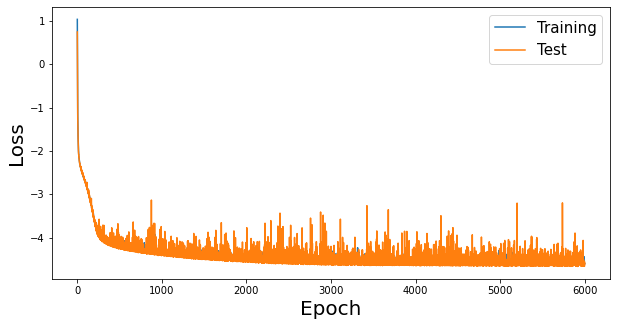

In [34]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,9])
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Test')

plt.xlabel('Epoch', fontsize= 20)
plt.ylabel('Loss', fontsize= 20)
plt.legend(fontsize=15)
#plt.yscale('log')

plt.savefig('LossvsEpoch11.png',dpi = 500)
plt.show()

In [35]:
# Predicciones del modelo
y_test2 = model11.predict(X11)
y_testT2 = model11.predict(XT)

292/292 [==============================] - 0s 1ms/step


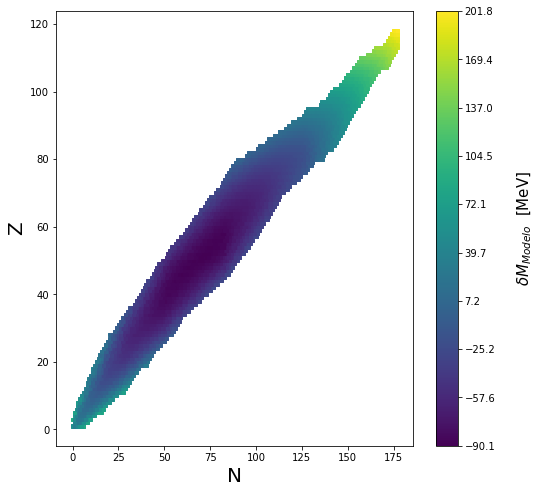

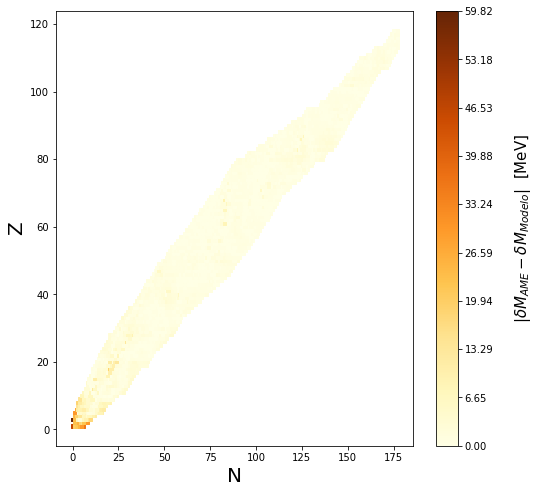

In [48]:
# Valores medios

# Predicciones del modelo

# Se "des-normalizan" las predicciones
D1 = (maxY11 - minY11)*y_test2[:,0].reshape(5826,-1) + minY11
D2 = (maxY11 - minY11)*Y11.reshape(5826,-1) + minY11

fig = plt.figure(figsize = (8,8))
plt.scatter(X11NN[:,2],X11NN[:,1], c = D1, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(D1),max(D1),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11MDNPREDmean.png',dpi = 500)
plt.show()

# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(X11NN[:,2],X11NN[:,1], c = abs(D1-D2), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(D1-D2)),max(abs(D1-D2)),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11MDNDIFFmean.png',dpi = 500)
plt.show()

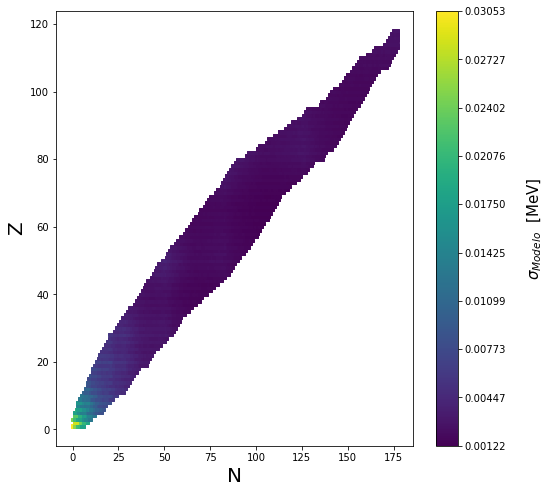

In [40]:
# Desviaciones estándar del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(X11NN[:,2],X11NN[:,1], c = y_test2[:,1].reshape(5826,-1), s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(y_test2[:,1].reshape(5826,-1)),max(y_test2[:,1].reshape(5826,-1)),10)).set_label(label='$\sigma_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11MDNPREDsigma.png',dpi = 500)
plt.show()

In [41]:
print("RMS del modelo: ", RMS(D1,D2)[0], 'MeV')

RMS del modelo:  2.757463987802449 MeV


# Extrapolación

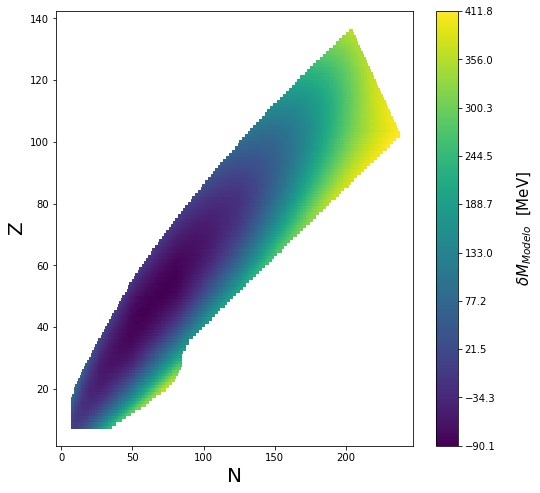

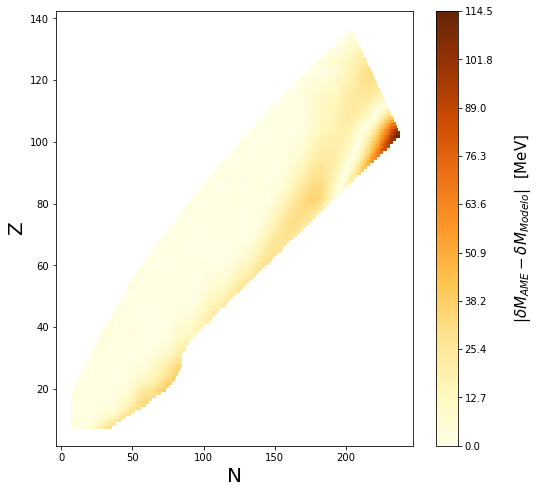

In [49]:
# Valores medios

# Predicciones del modelo

# Se "des-normalizan" las predicciones
D1 = (maxY11 - minY11)*y_testT2[:,0].reshape(9318,-1) + minY11
D2 = (maxY11 - minY11)*YT.reshape(9318,-1) + minY11

fig = plt.figure(figsize = (8,8))
plt.scatter(XTNN[:,2],XTNN[:,1], c = D1, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(D1),max(D1),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11TMDNPREDmean.png',dpi = 500)
plt.show()

# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(XTNN[:,2],XTNN[:,1], c = abs(D1-D2), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(D1-D2)),max(abs(D1-D2)),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11TMDNDIFFmean.png',dpi = 500)
plt.show()

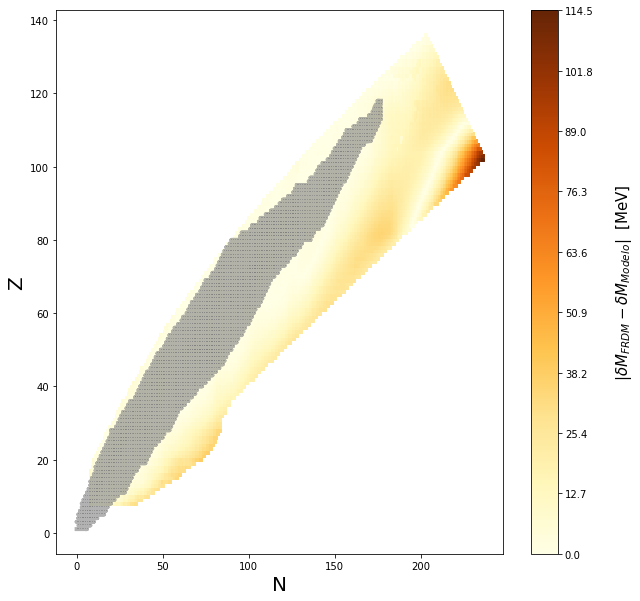

In [57]:
# Se quitan los valores de FRDM en los datos de training 
Z11_TRUNC =  np.array(XT[:,1])
N11_TRUNC = np.array(XT[:,2])
PREDFRDM_TRUNC = np.array(y_testT2)
YT_TRUNC = YT 
        
for i in range(0,len(X11[:,2])):
    for j in range(0,len(N11_TRUNC)):
        
        if (X11[i,2] == N11_TRUNC[j]):
            if (X11[i,1] == Z11_TRUNC[j]):
                
                Z11_TRUNC = np.delete(Z11_TRUNC, j)
                N11_TRUNC = np.delete(N11_TRUNC, j)
                PREDFRDM_TRUNC = np.delete(PREDFRDM_TRUNC, j)
                YT_TRUNC = np.delete(YT_TRUNC, j)
                break
                
# Diferencias
diff = abs(D1-D2)


fig = plt.figure(figsize = (10,10))
plt.scatter(XTNN[:,2],XTNN[:,1], c = abs(D1-D2), s = 10, marker=',', cmap = 'YlOrBr')

#plt.scatter((max(X11NN[:,2])-min(X11NN[:,2]))*N11_TRUNC+min(X11NN[:,2]), (max(X11NN[:,1])-min(X11NN[:,1]))*Z11_TRUNC+min(X11NN[:,1]), c = diff, s = 10, marker=',', cmap = 'YlOrBr')
#plt.plot((max(X11NN[:,2])-min(X11NN[:,2]))*X11[:,2]+min(X11NN[:,2]), (max(X11NN[:,1])-min(X11NN[:,1]))*X11[:,1]+min(X11NN[:,1]), color ='grey', marker=',', linewidth=4, alpha = 0.6)
plt.plot(X11NN[:,2], X11NN[:,1], color ='grey', marker=',', linewidth=4, alpha = 0.6)


plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(diff),max(diff),10)).set_label(label='|$\delta M_{FRDM}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11TRFDIFF_TRUNCv3.png',dpi = 500)
plt.show()